In [1]:
import os
os.chdir('../')

In [2]:
import random

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from sklearn.linear_model import LogisticRegression

from src.DRL.qnetwork import QNetwork
from src.XAI.concept import Concept
from src.XAI.concepts import concept_instances

In [3]:
env_steps = Concept.load_concept_data()
model_path = "runs/20241115-172401/model_1990000.pt"
model = QNetwork(model_path=model_path)

action_names = ['NOOP', 'LEFT', 'RIGHT', 'JUMP', 'DODGE']
activation_layers = [1, 3, 5, 8]

/home/jacob/DRL-CAV/.venv/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Loaded model: 20241115-172401-1990000


In [4]:
def prepare_probe(concept, model, layer, max_size=10000):
    concept.prepare_data(env_steps, max_size=max_size)
    train_obs = torch.tensor(concept.train_obs.copy()).float()
    train_values = torch.tensor(concept.train_values, dtype=torch.float32)
    test_obs = torch.tensor(concept.test_obs.copy()).float()
    test_values = torch.tensor(concept.test_values, dtype=torch.float32)

    _, acts_dict_train = model(train_obs, return_acts=True)
    _, acts_dict_test = model(test_obs, return_acts=True)

    x_data_train = acts_dict_train[layer].flatten(start_dim=1).cpu().numpy()
    y_data_train = train_values.view(train_values.shape[0]).cpu().numpy()
    x_data_test = acts_dict_test[layer].flatten(start_dim=1).cpu().numpy()
    y_data_test = test_values.view(test_values.shape[0]).cpu().numpy()

    lr = LogisticRegression(max_iter=1000, solver='liblinear', penalty='l1', C=1)
    lr.fit(x_data_train, y_data_train)
    probe_accuracy = round(lr.score(x_data_test, y_data_test), 2)

    flat_weights = lr.coef_[0]
    norm_direction = flat_weights #/ np.linalg.norm(flat_weights)

    return lr, norm_direction, acts_dict_train, acts_dict_test, probe_accuracy

In [5]:
def compute_tcav_scores(model, layer, norm_direction, acts_dict_test, q_value_strategy):
    # Zero gradients to prevent accumulation
    for param in model.network.parameters():
        if param.grad is not None:
            param.grad.zero_()
            
    test_activations = acts_dict_test[layer]
    if test_activations.grad is not None: # Why was this needed????
        test_activations.grad.zero_()
    test_activations.requires_grad_(True)
    test_activations.retain_grad()
    output_values = q_value_strategy(model, test_activations, layer)
    output_values.backward(torch.ones_like(output_values))
    activations_grad = test_activations.grad.clone()
    flat_activations_grad = activations_grad.flatten(start_dim=1).cpu().numpy()
    directional_derivatives = np.dot(flat_activations_grad, norm_direction)

    positive_fraction = np.mean(directional_derivatives > 0)
    return positive_fraction, directional_derivatives

In [6]:
def q_value_per_action(model, activations, layer, action_idx):
    q_value = model.network[layer + 1:](activations)[:, action_idx]
    return q_value

def q_value_softmax(model, activations, layer, action_idx):
    relative_q_value = model.network[layer + 1:](activations).softmax(dim=-1)[:, action_idx]
    return relative_q_value

def q_value_ratio(action1_idx, action2_idx):
    def compute_ratio(model, activations, layer):
        q_values = model.network[layer + 1:](activations)
        q_value_ratio = q_values[:, action1_idx] / (q_values[:, action1_idx] + q_values[:, action2_idx])
        return q_value_ratio
    return compute_ratio

def q_value_per_action(model, activations, layer, action_idx):
    q_values = model.network[layer + 1:](activations)
    q_value = q_values[:, action_idx]
    return q_value

def q_value_softmax(model, activations, layer, action_idx):
    q_values = model.network[layer + 1:](activations)
    relative_q_value = q_values.softmax(dim=-1)[:, action_idx]
    return relative_q_value

def q_value_max_output(model, activations, layer):
    q_values = model.network[layer + 1:](activations)
    max_q_value, max_idx = q_values.max(dim=1)
    return max_q_value

In [7]:
def tcav_analysis(concept, model, layers, q_value_strategy, method_name='TCAV'):
    scores = []
    directional_derivatives_all_layers = []
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()

    for ax, layer in zip(axes, layers):
        # Prepare probe and get necessary components
        lr, norm_direction, acts_dict_train, acts_dict_test, probe_accuracy = prepare_probe(concept, model, layer)

        # Compute TCAV scores
        positive_fraction, directional_derivatives = compute_tcav_scores(
            model, layer, norm_direction, acts_dict_test, q_value_strategy
        )
        scores.append(positive_fraction)
        directional_derivatives_all_layers.append(directional_derivatives)

        # Plotting with smooth distributions using KDE if it is not layer 8
        if layer != 8:
            sns.kdeplot(directional_derivatives, bw_adjust=1, ax=ax, fill=True)
        else:
            ax.hist(directional_derivatives, bins=30, edgecolor='black')
        ax.set_xlabel('Conceptual Sensitivity')
        ax.set_ylabel('Density')
        ax.set_title(f"{concept.name} | {method_name} Layer {layer} | Concept Score: {probe_accuracy:.2f} | TCAV Score: {positive_fraction:.2f}")
        ax.axvline(x=0, color='r', linestyle='--', label='Zero')

    # Hide any unused subplots
    for ax in axes[len(layers):]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

def tcav_multiple_actions_analysis(concept, model, layers, action_names, q_value_strategy, method_name='TCAV'):
    scores_per_layer = {layer: {} for layer in layers}
    directional_derivatives_all_layers = {layer: {} for layer in layers}
    fig, axes = plt.subplots(2, 2, figsize=(20, 15))
    axes = axes.flatten()

    for ax, layer in zip(axes, layers):
        # Prepare probe and get necessary components
        lr, norm_direction, acts_dict_train, acts_dict_test, probe_accuracy = prepare_probe(concept, model, layer)

        # Iterate over each action
        for action_idx, action_name in enumerate(action_names):
            # Define a lambda to include additional parameters if any
            q_strategy = lambda m, a, l: q_value_strategy(m, a, l, action_idx=action_idx)

            # Compute TCAV scores
            positive_fraction, directional_derivatives = compute_tcav_scores(
                model, layer, norm_direction, acts_dict_test, q_strategy
            )
            scores_per_layer[layer][action_name] = positive_fraction
            directional_derivatives_all_layers[layer][action_name] = directional_derivatives

            # Plotting with smooth distributions using KDE
            sns.kdeplot(directional_derivatives, bw_adjust=1, ax=ax, fill=True, label=f"{action_name} (Score: {positive_fraction:.2f})")

        # Customize the subplot
        ax.set_xlabel('Conceptual Sensitivity')
        ax.set_ylabel('Density')
        ax.set_title(f"{concept.name} | {method_name} | Layer {layer} | Concept Score: {probe_accuracy:.2f}")
        ax.axvline(x=0, color='r', linestyle='--', label='Zero')
        ax.legend()

    # Hide any unused subplots
    for ax in axes[len(layers):]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

## PLOTTING TIME!

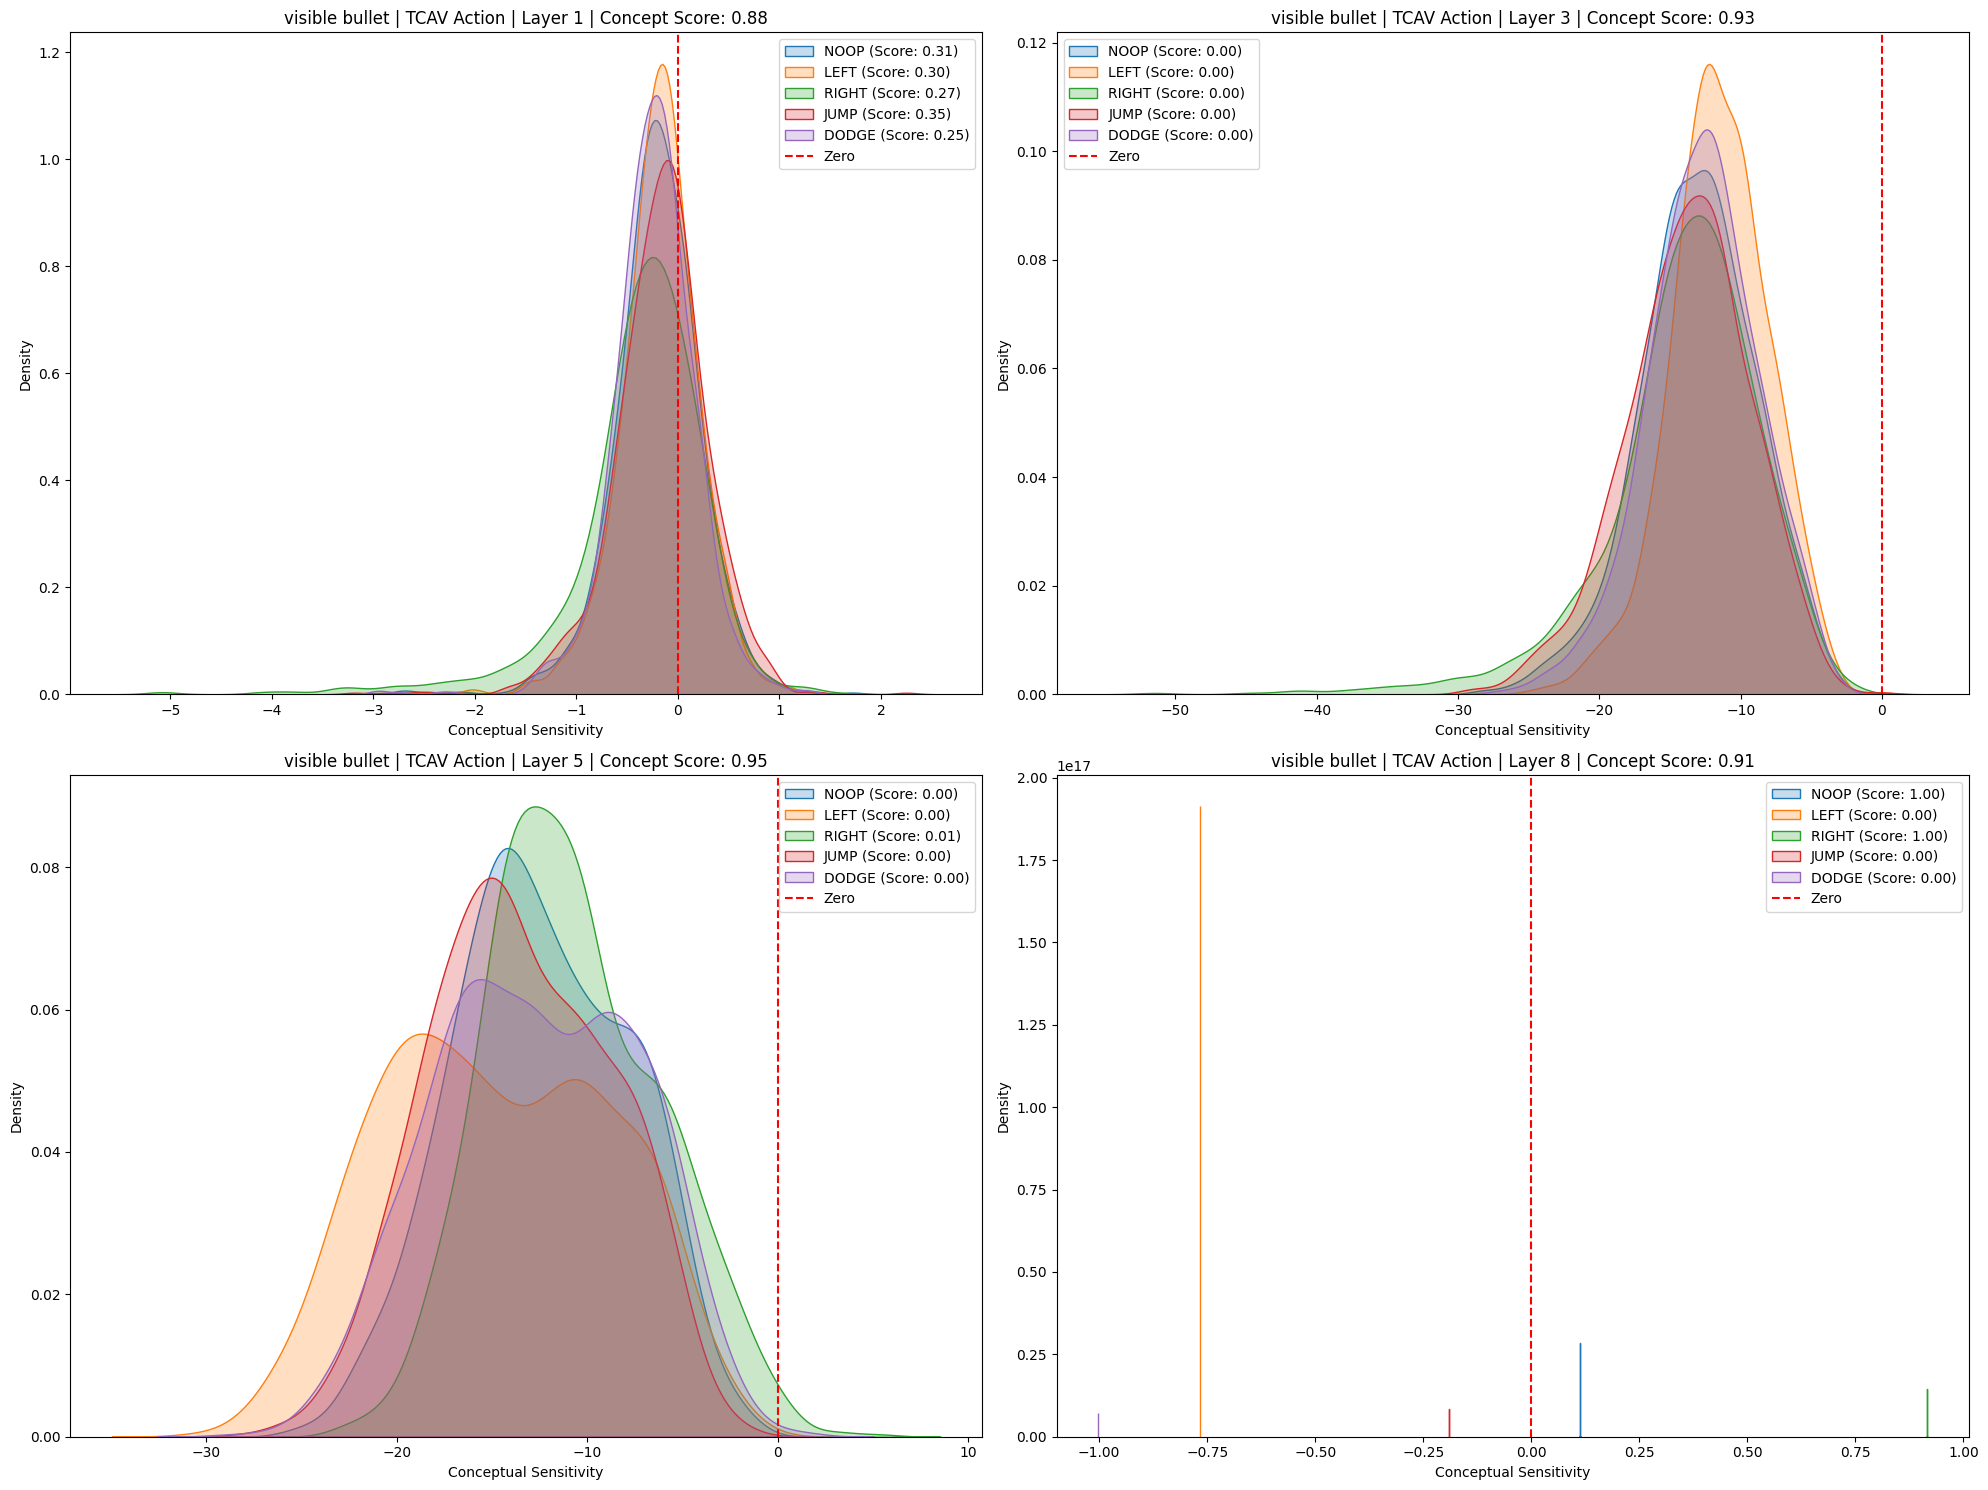

In [8]:
concept = concept_instances['Visible bullet']

tcav_multiple_actions_analysis(
    concept=concept,
    model=model,
    layers=activation_layers,
    action_names=action_names,
    q_value_strategy=q_value_per_action,
    method_name="TCAV Action"
)

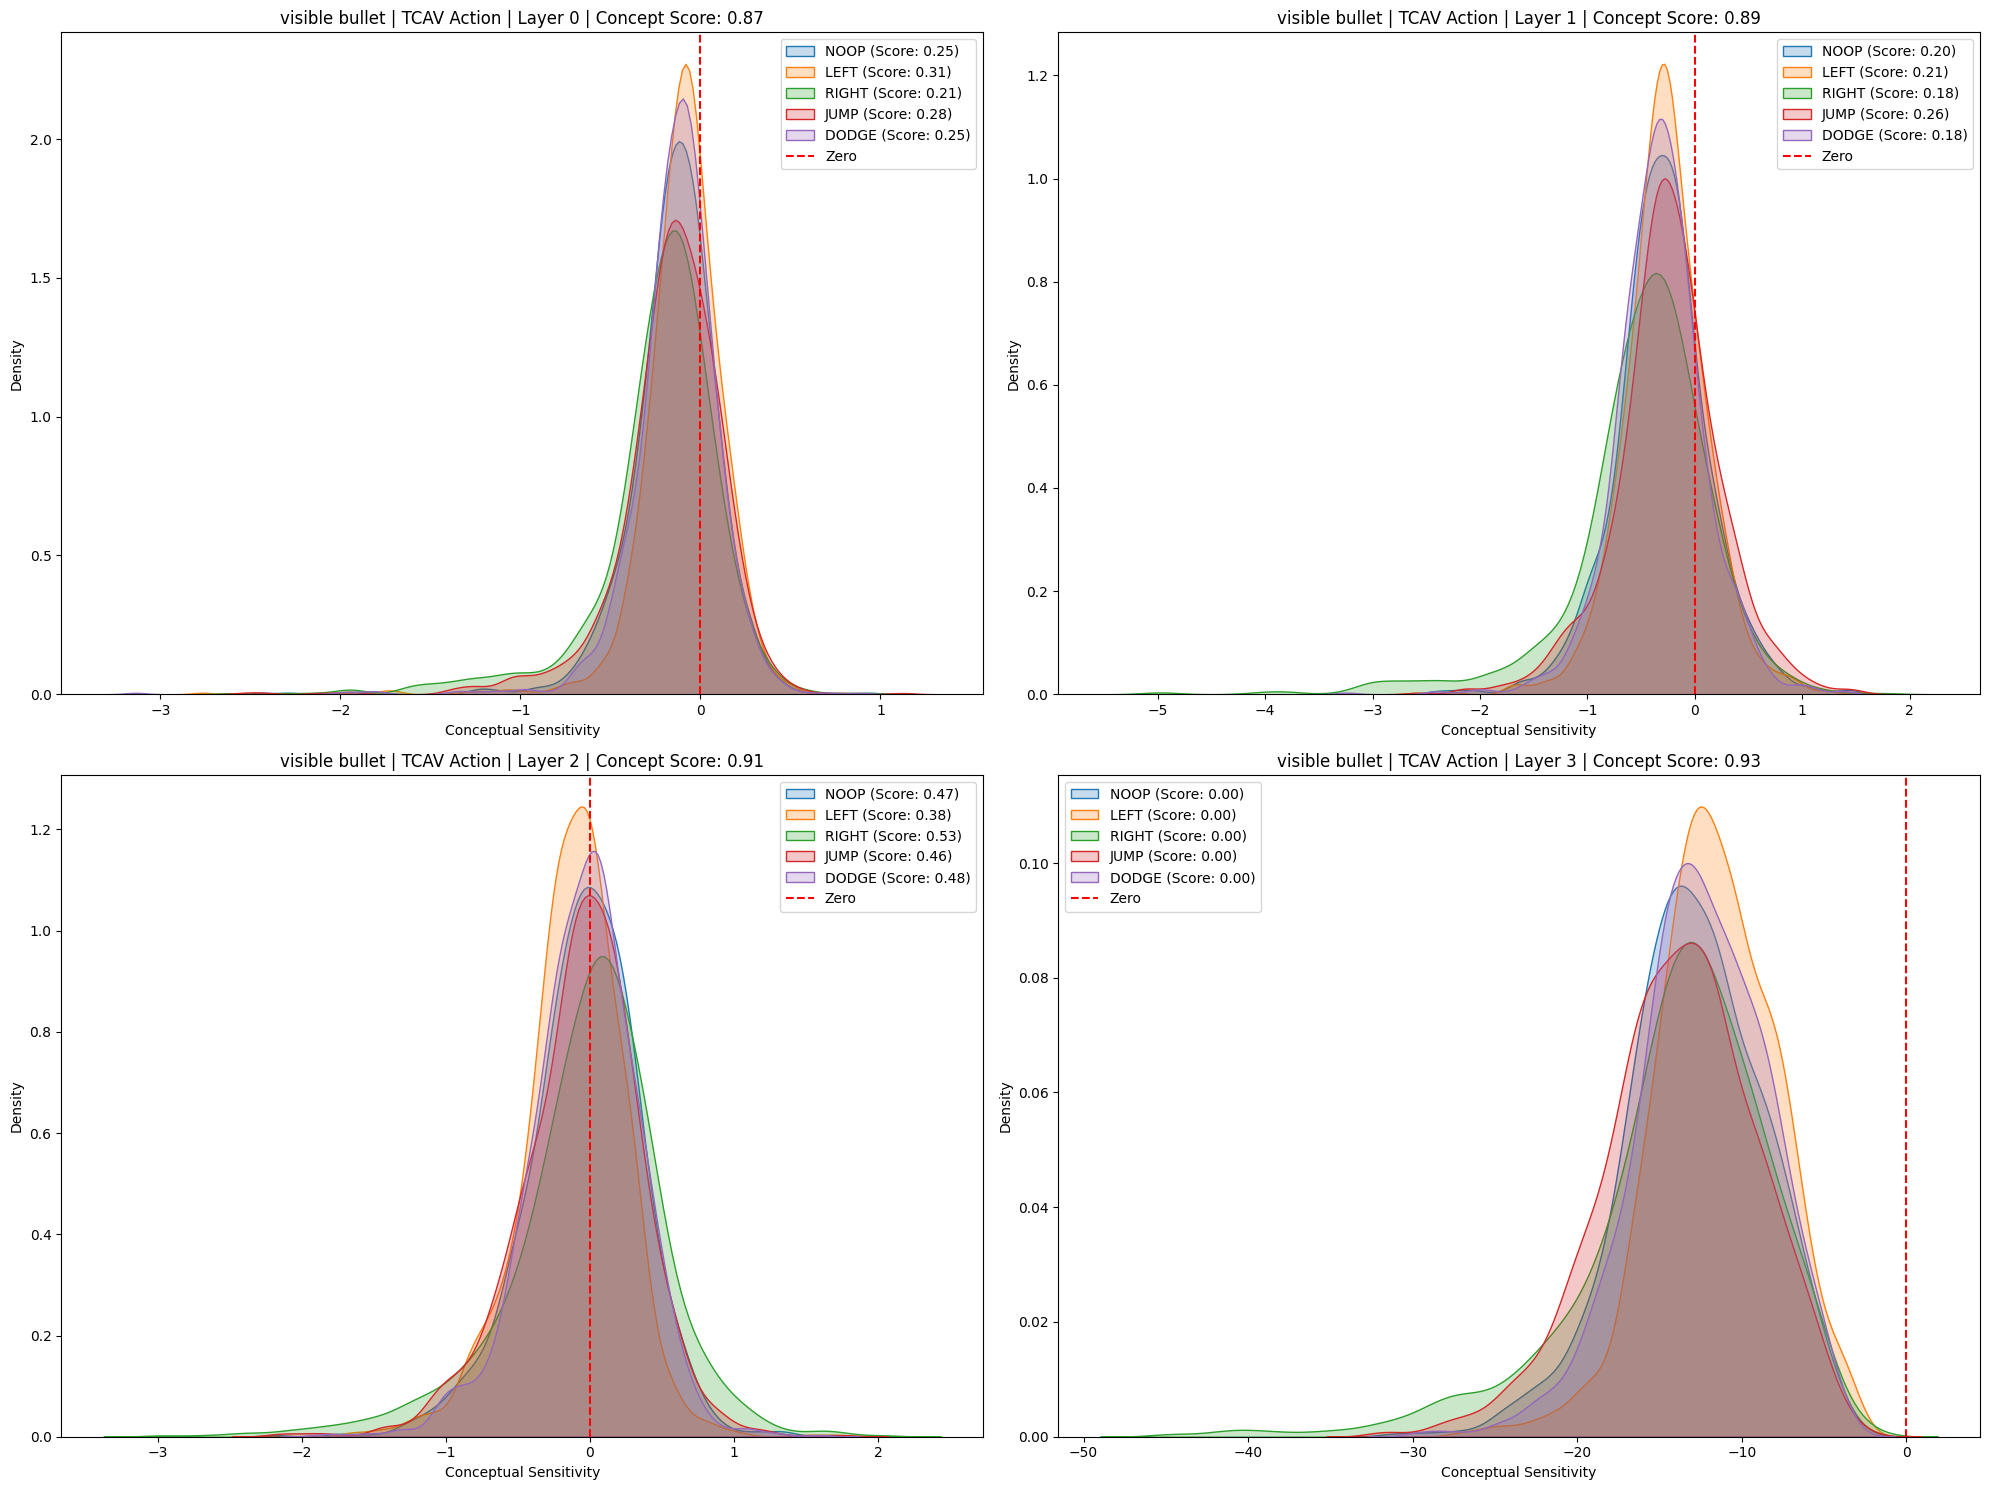

In [9]:
concept = concept_instances['Visible bullet']

tcav_multiple_actions_analysis(
    concept=concept,
    model=model,
    layers=[0, 1, 2, 3],
    action_names=action_names,
    q_value_strategy=q_value_per_action,
    method_name="TCAV Action"
)

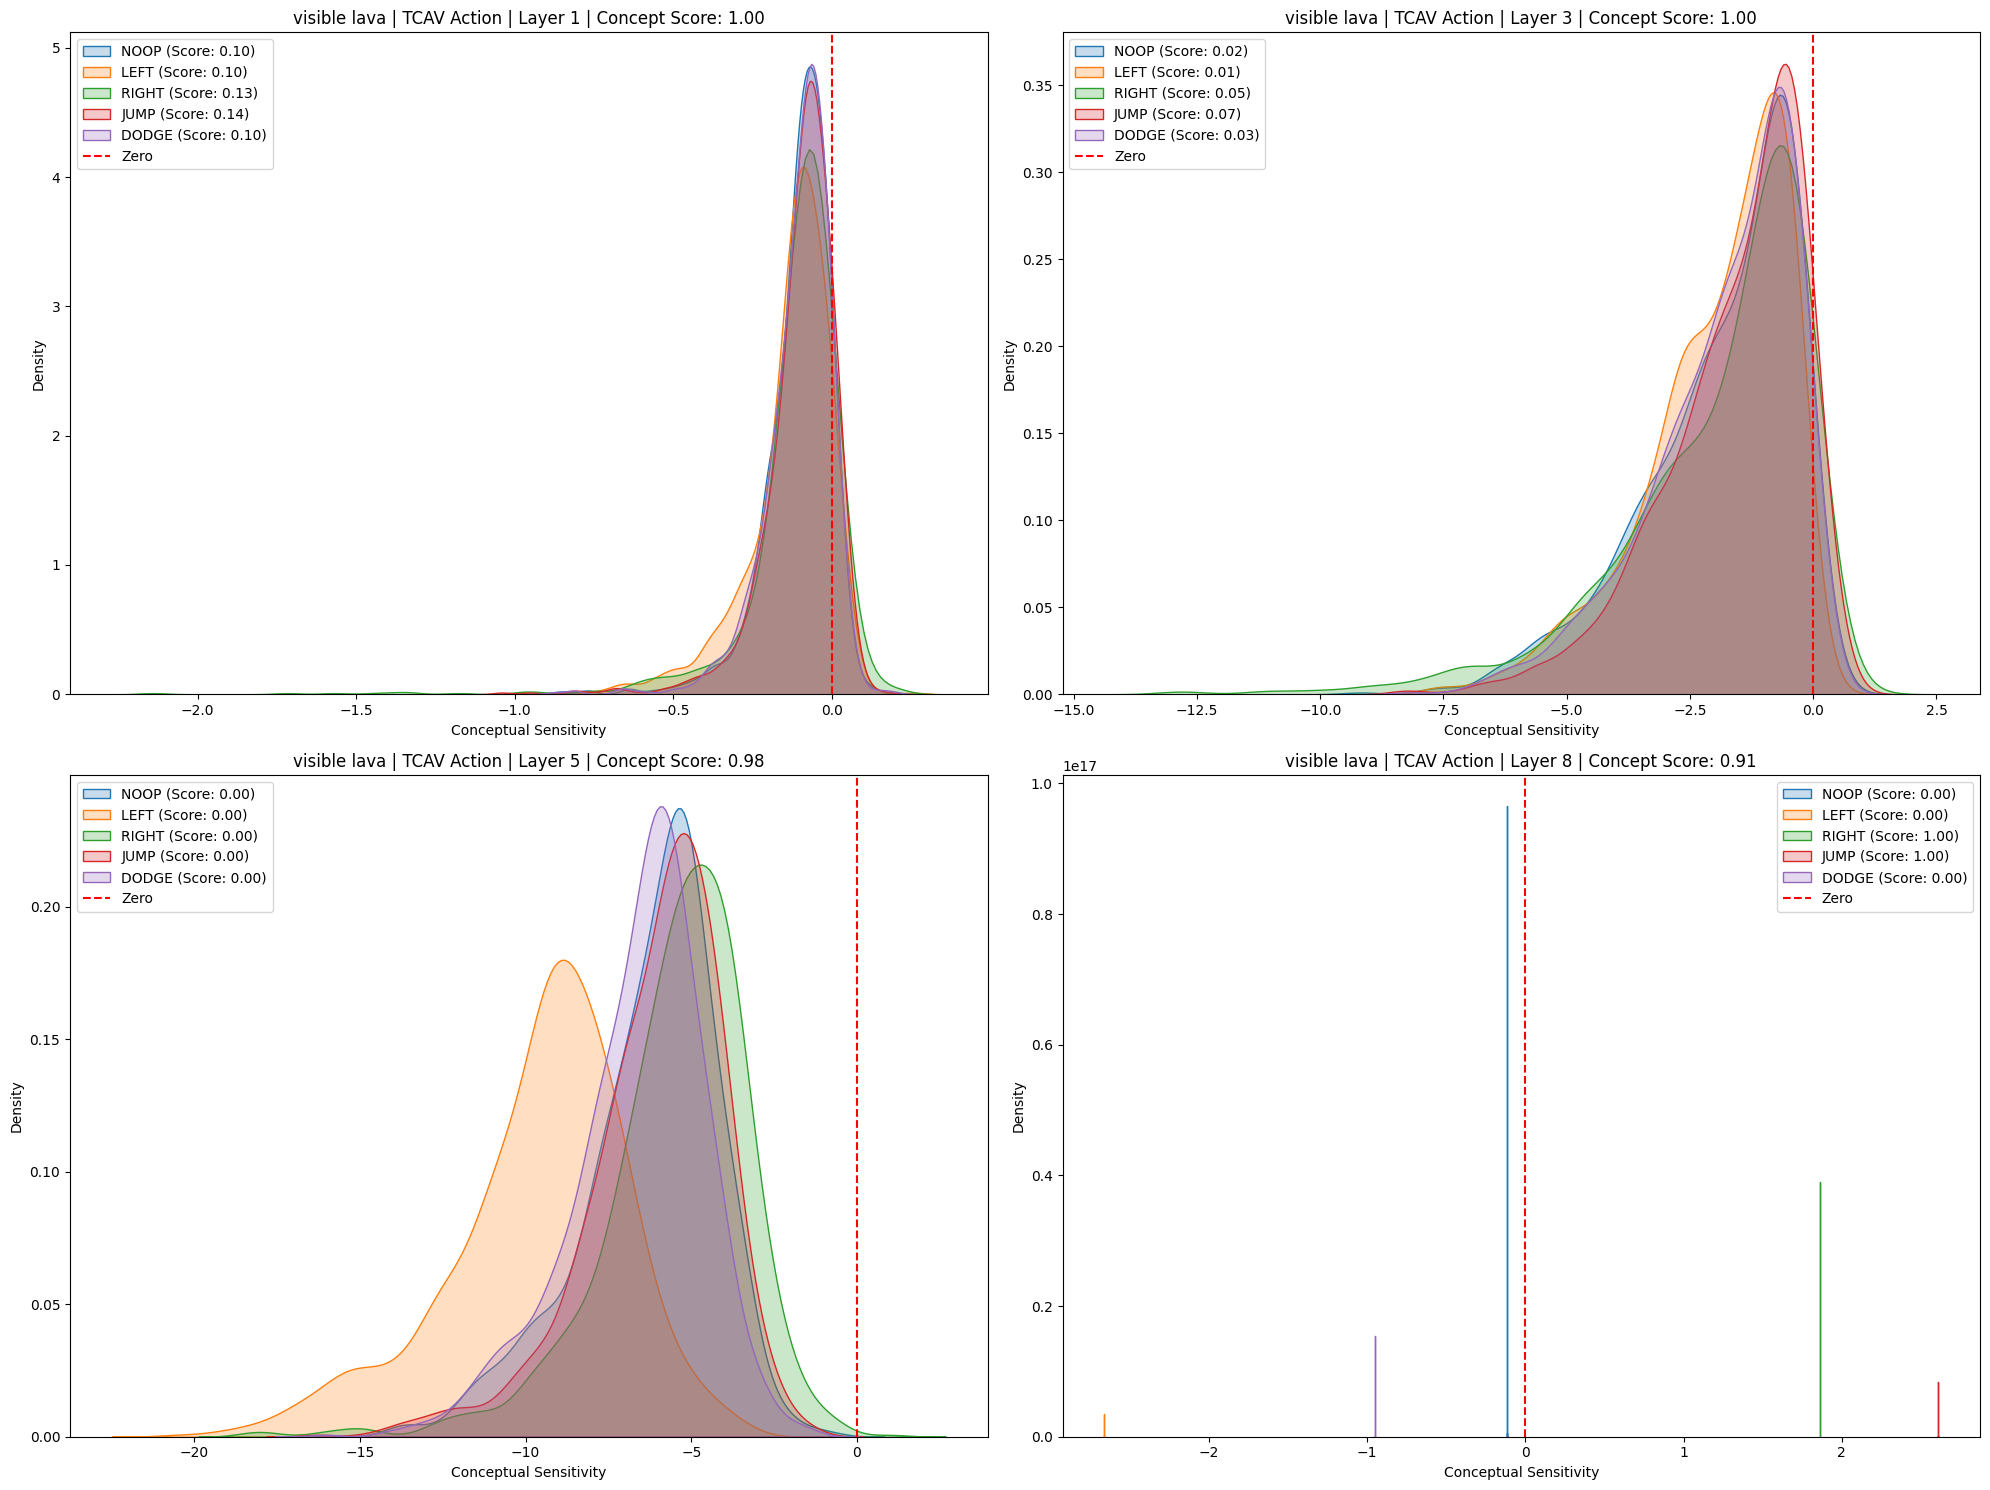

In [10]:
concept = concept_instances['Visible lava']

tcav_multiple_actions_analysis(
    concept=concept,
    model=model,
    layers=activation_layers,
    action_names=action_names,
    q_value_strategy=q_value_per_action,
    method_name="TCAV Action"
)

/tmp/ipykernel_6396/718800832.py:58: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(directional_derivatives, bw_adjust=1, ax=ax, fill=True, label=f"{action_name} (Score: {positive_fraction:.2f})")


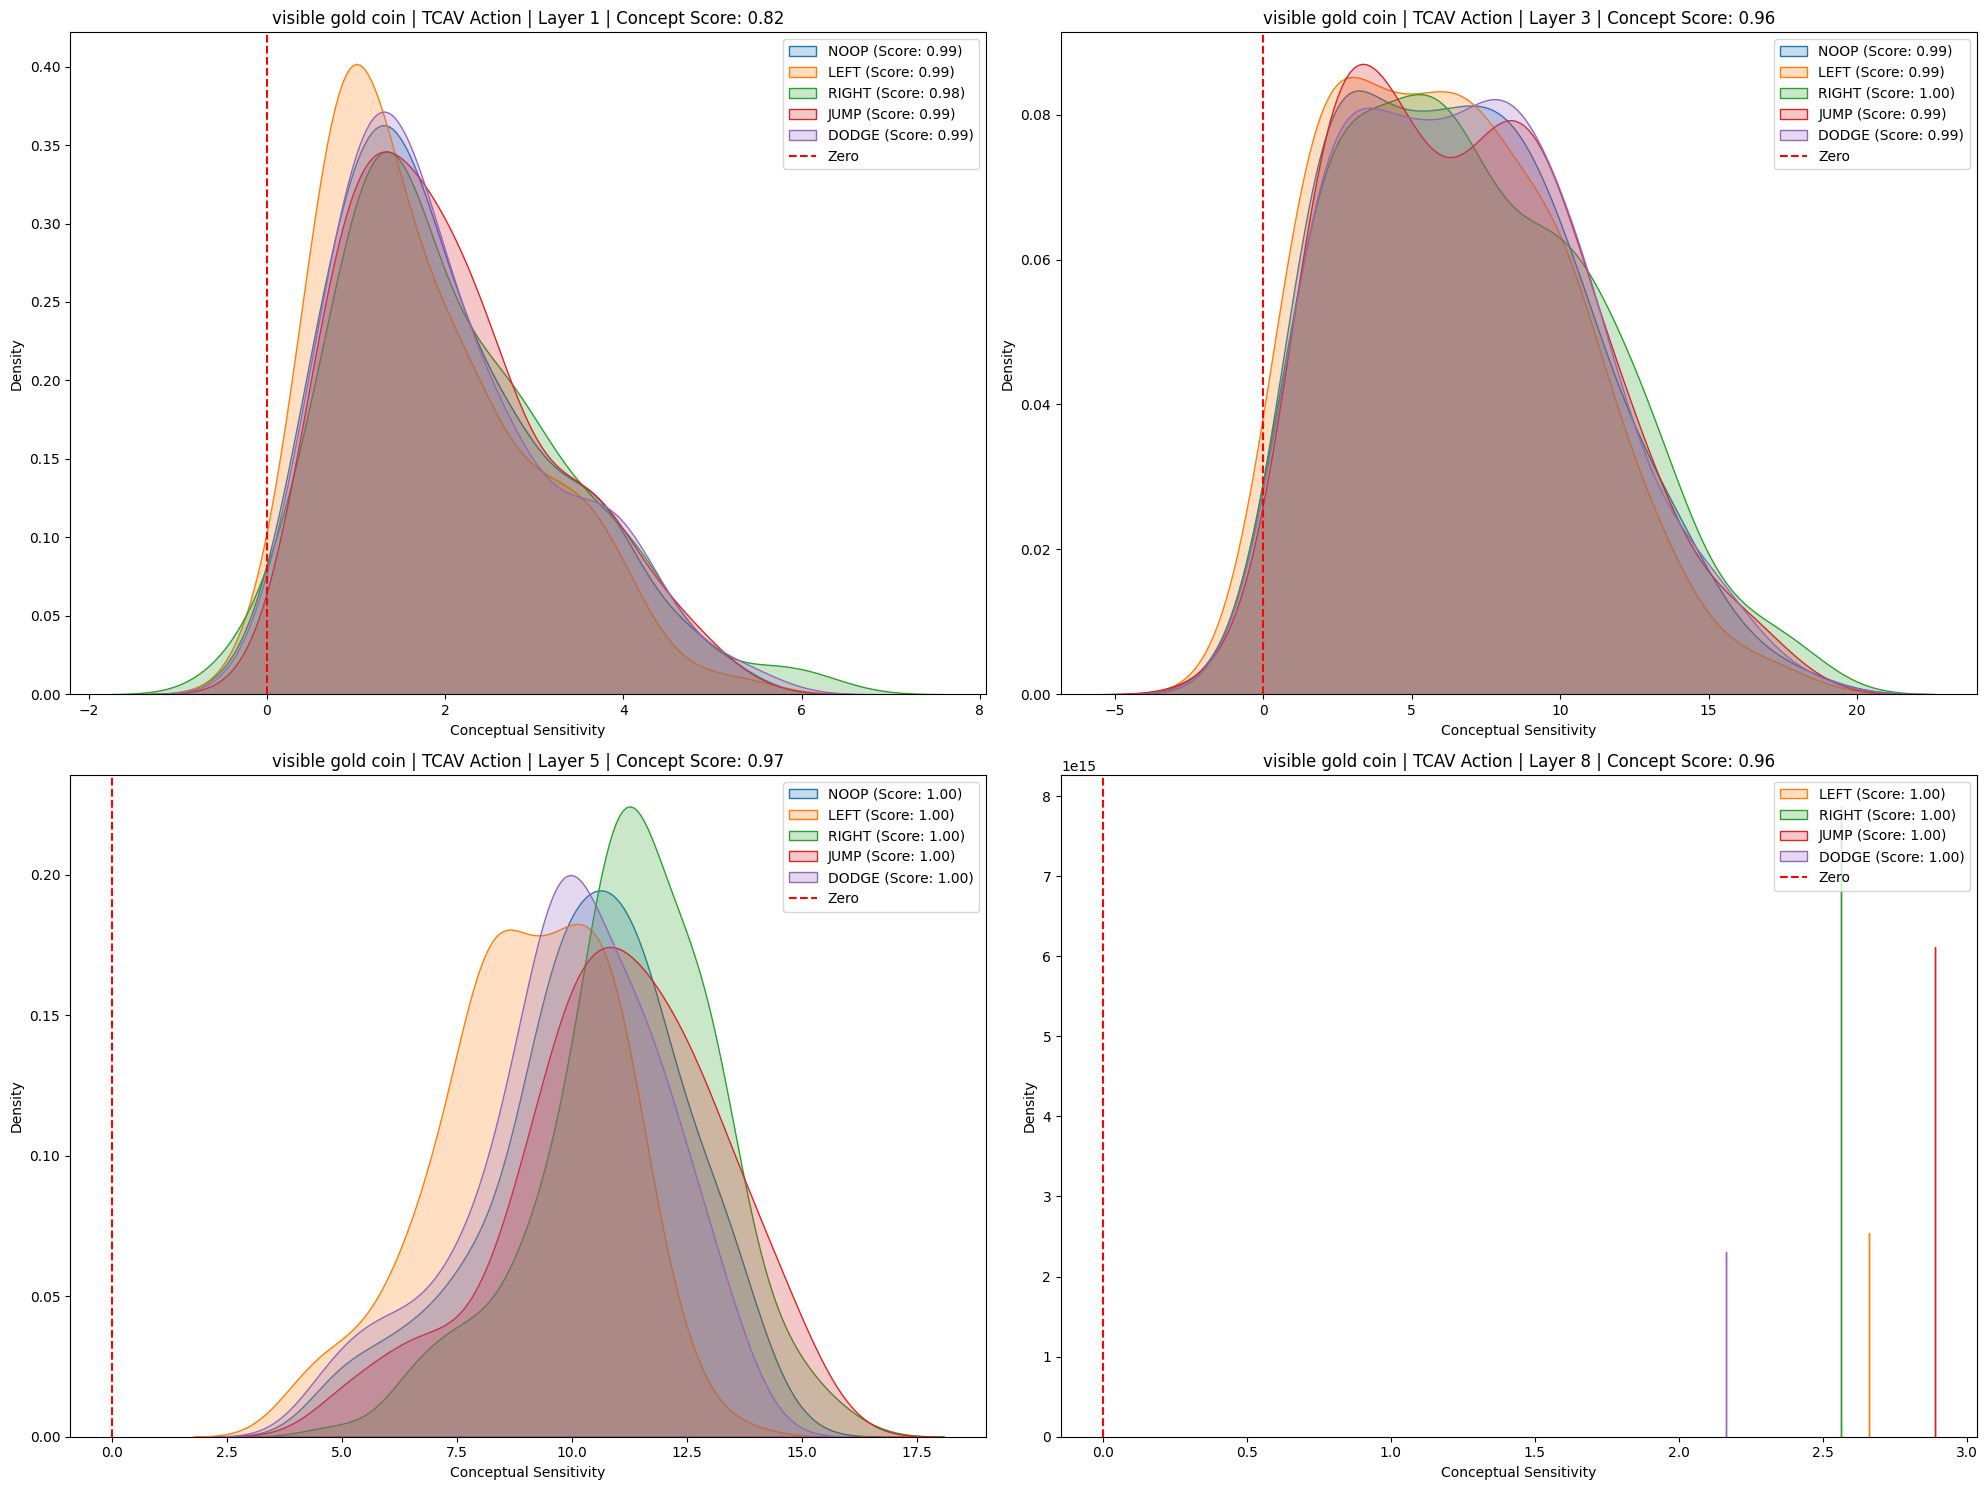

In [11]:
concept = concept_instances['Visible gold coin']

tcav_multiple_actions_analysis(
    concept=concept,
    model=model,
    layers=activation_layers,
    action_names=action_names,
    q_value_strategy=q_value_per_action,
    method_name="TCAV Action"
)

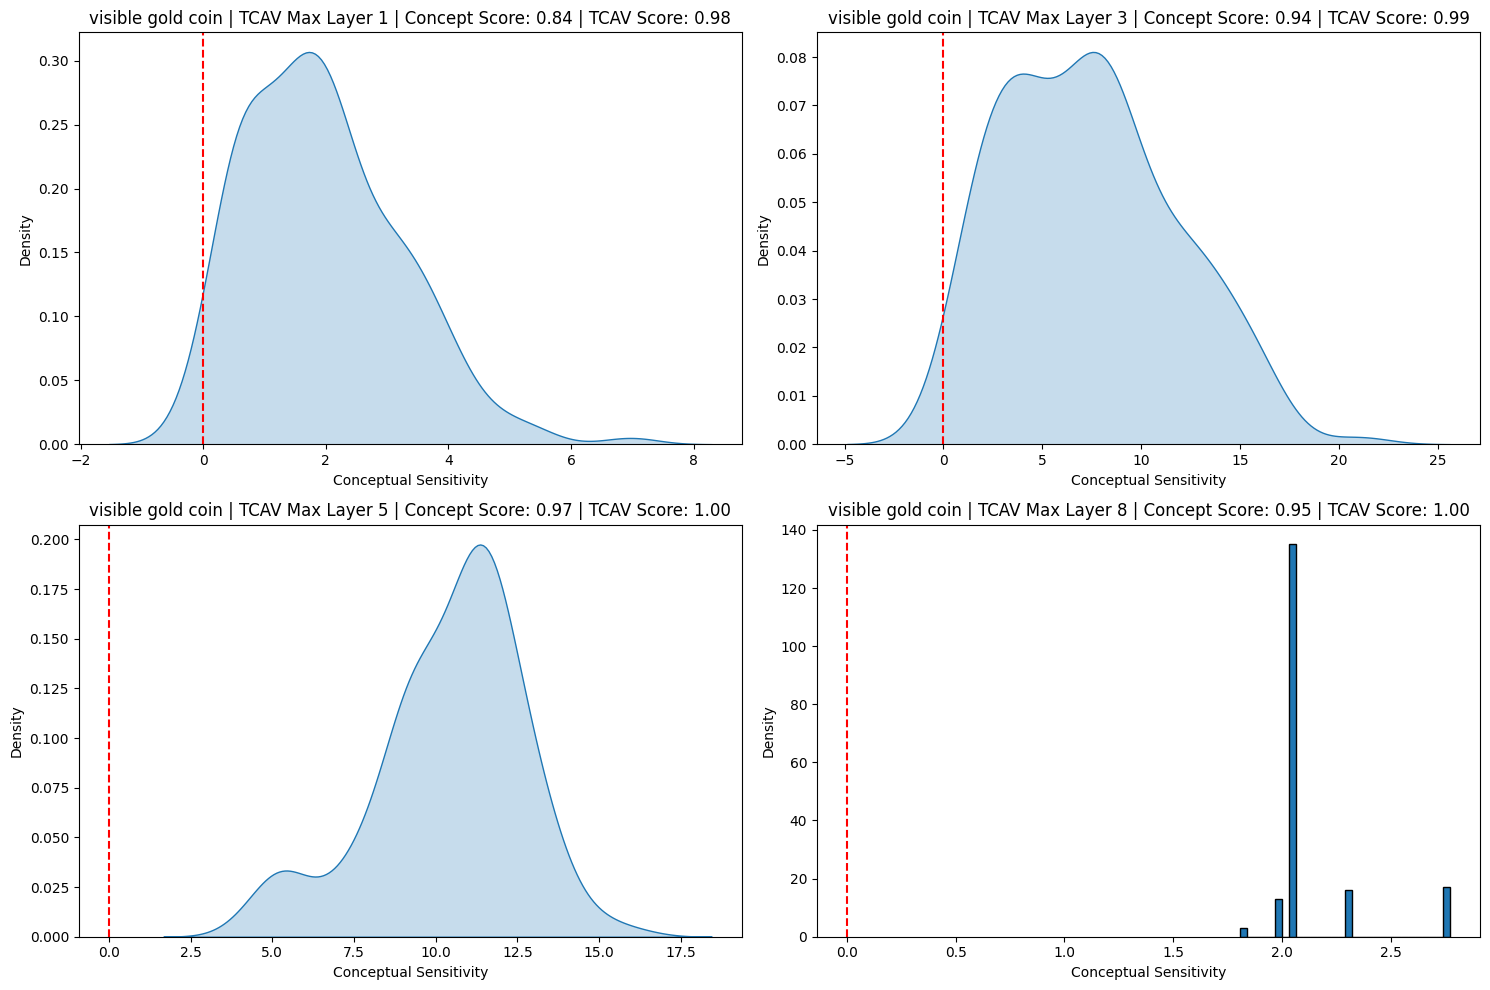

In [12]:
concept = concept_instances['Visible gold coin']

tcav_analysis(
    concept=concept,
    model=model,
    layers=activation_layers,
    q_value_strategy=q_value_max_output,
    method_name="TCAV Max"
)

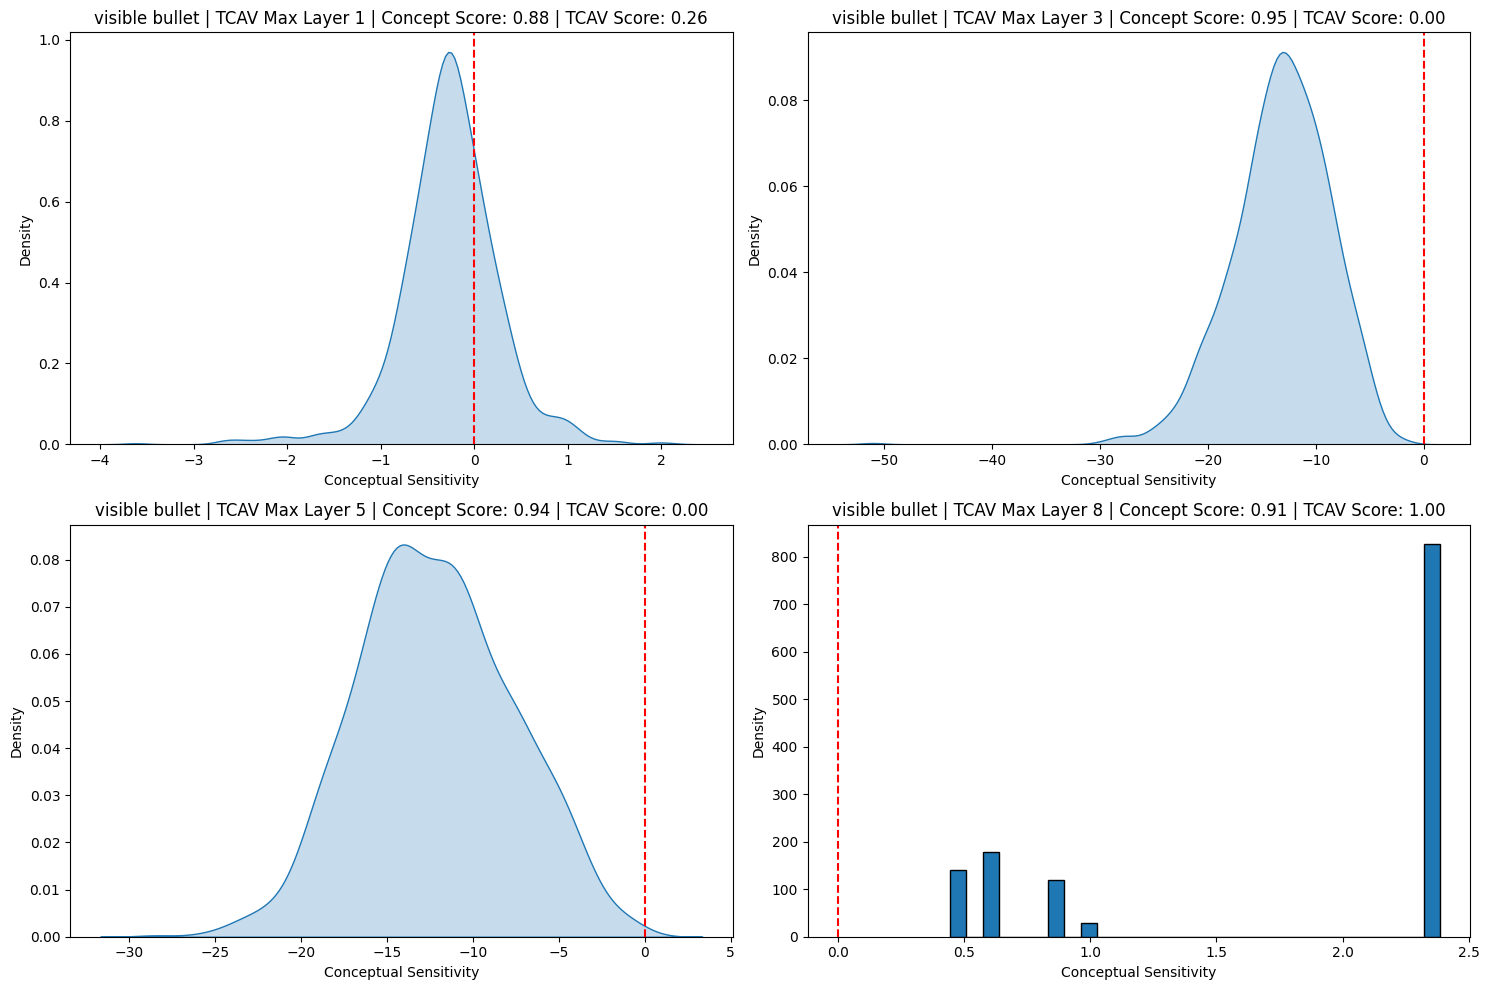

In [13]:
concept = concept_instances['Visible bullet']

tcav_analysis(
    concept=concept,
    model=model,
    layers=activation_layers,
    q_value_strategy=q_value_max_output,
    method_name="TCAV Max"
)

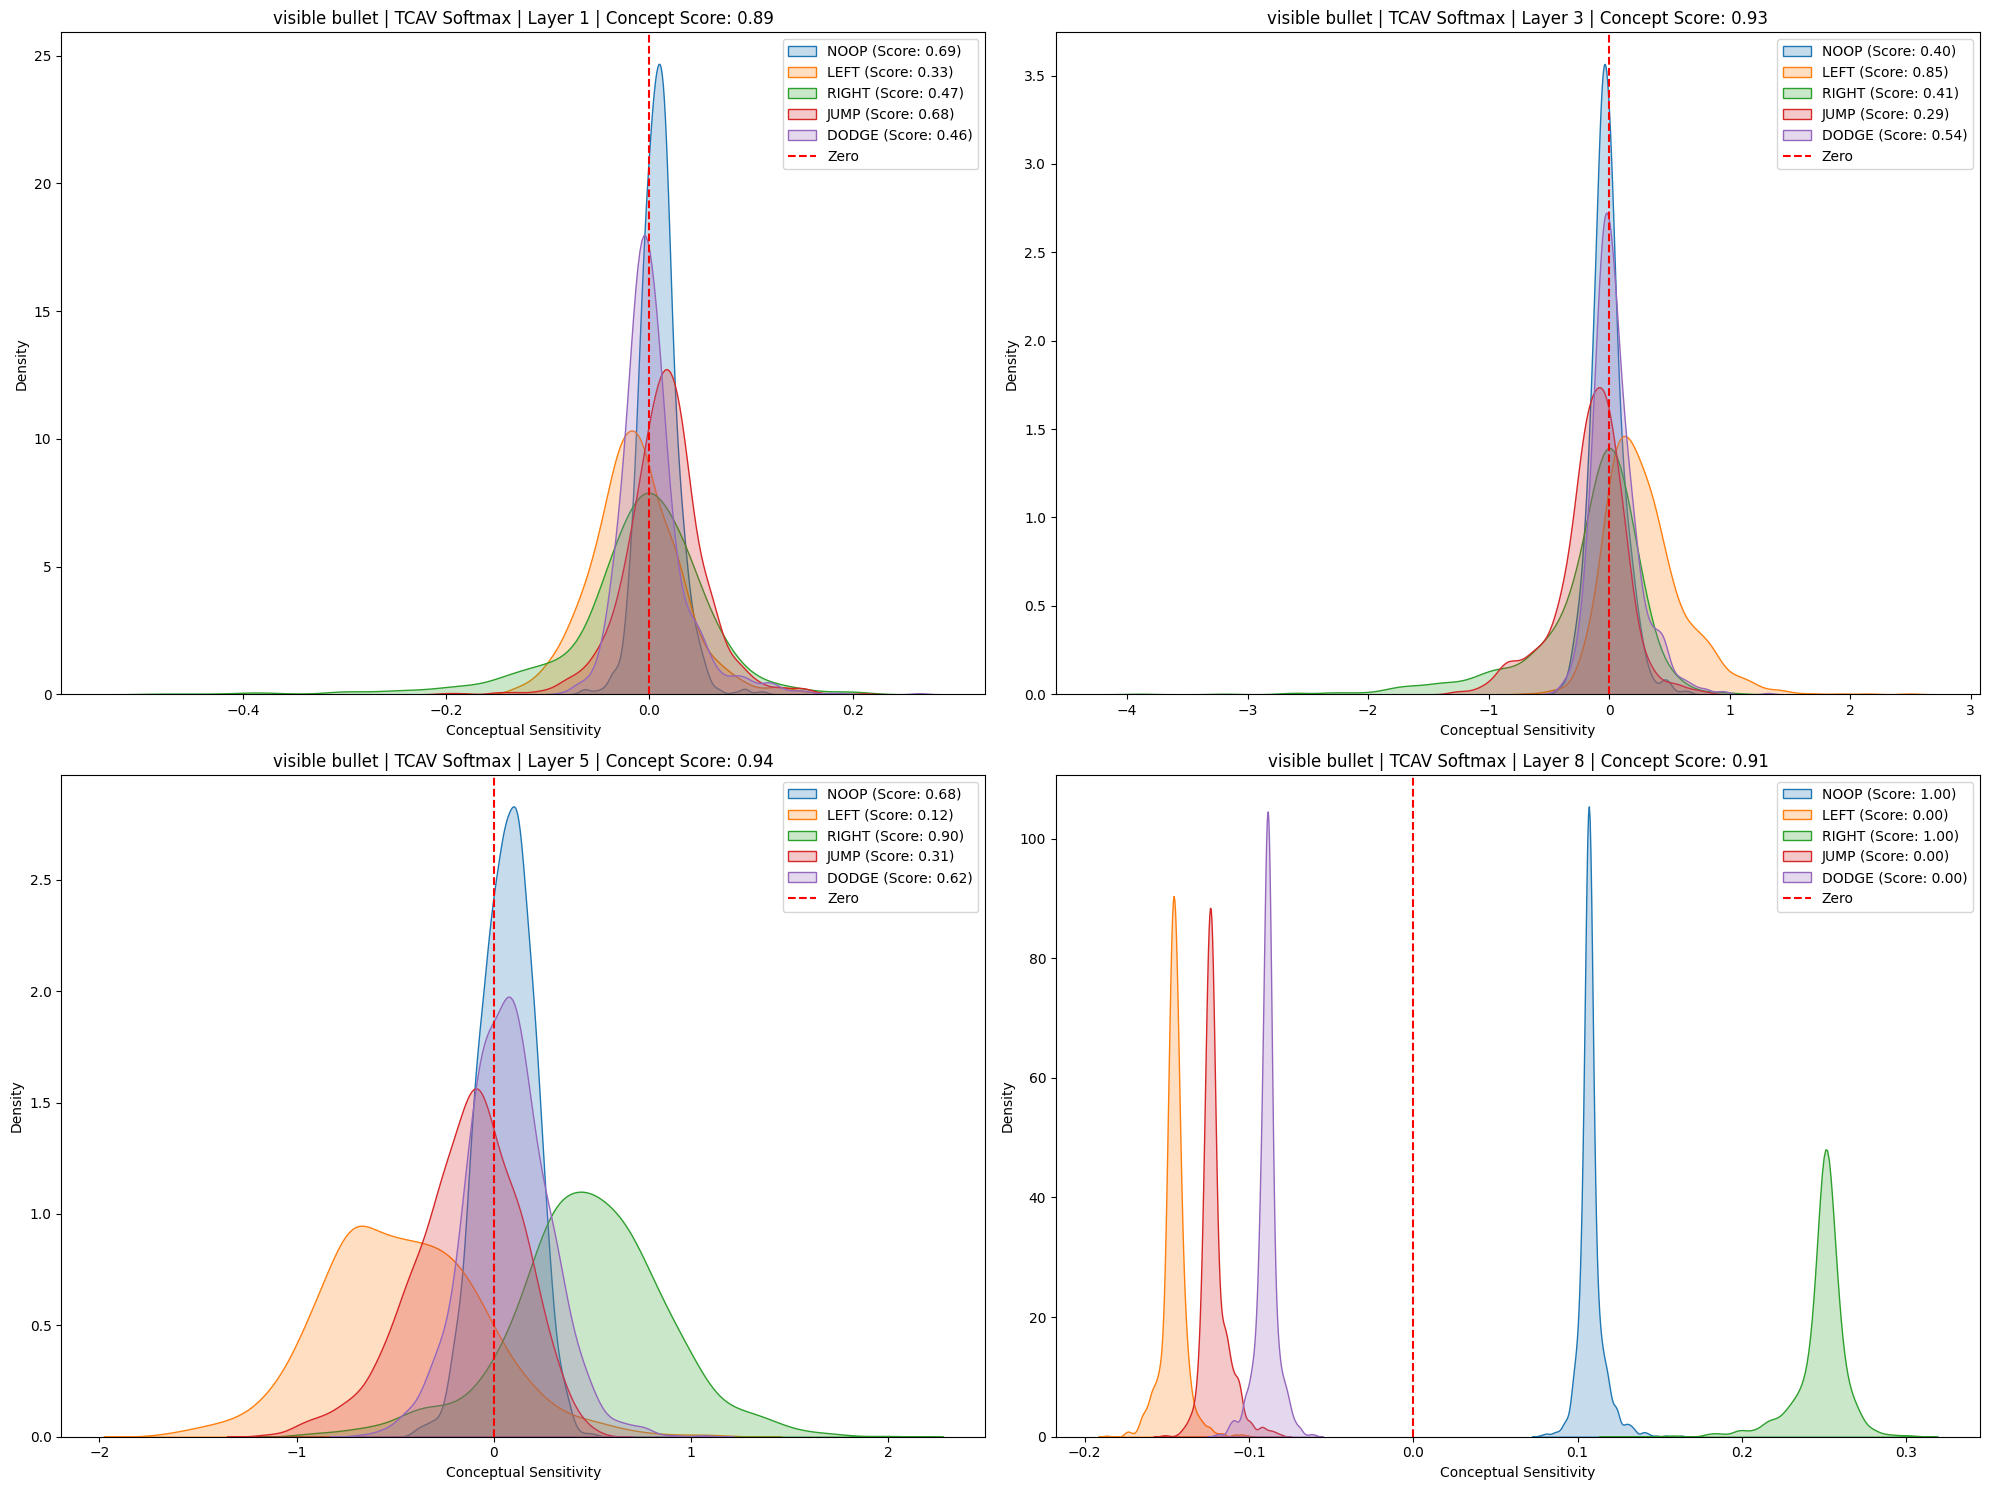

In [14]:
concept = concept_instances['Visible bullet']

tcav_multiple_actions_analysis(
    concept=concept,
    model=model,
    layers=activation_layers,
    action_names=action_names,
    q_value_strategy=q_value_softmax,
    method_name="TCAV Softmax"
)

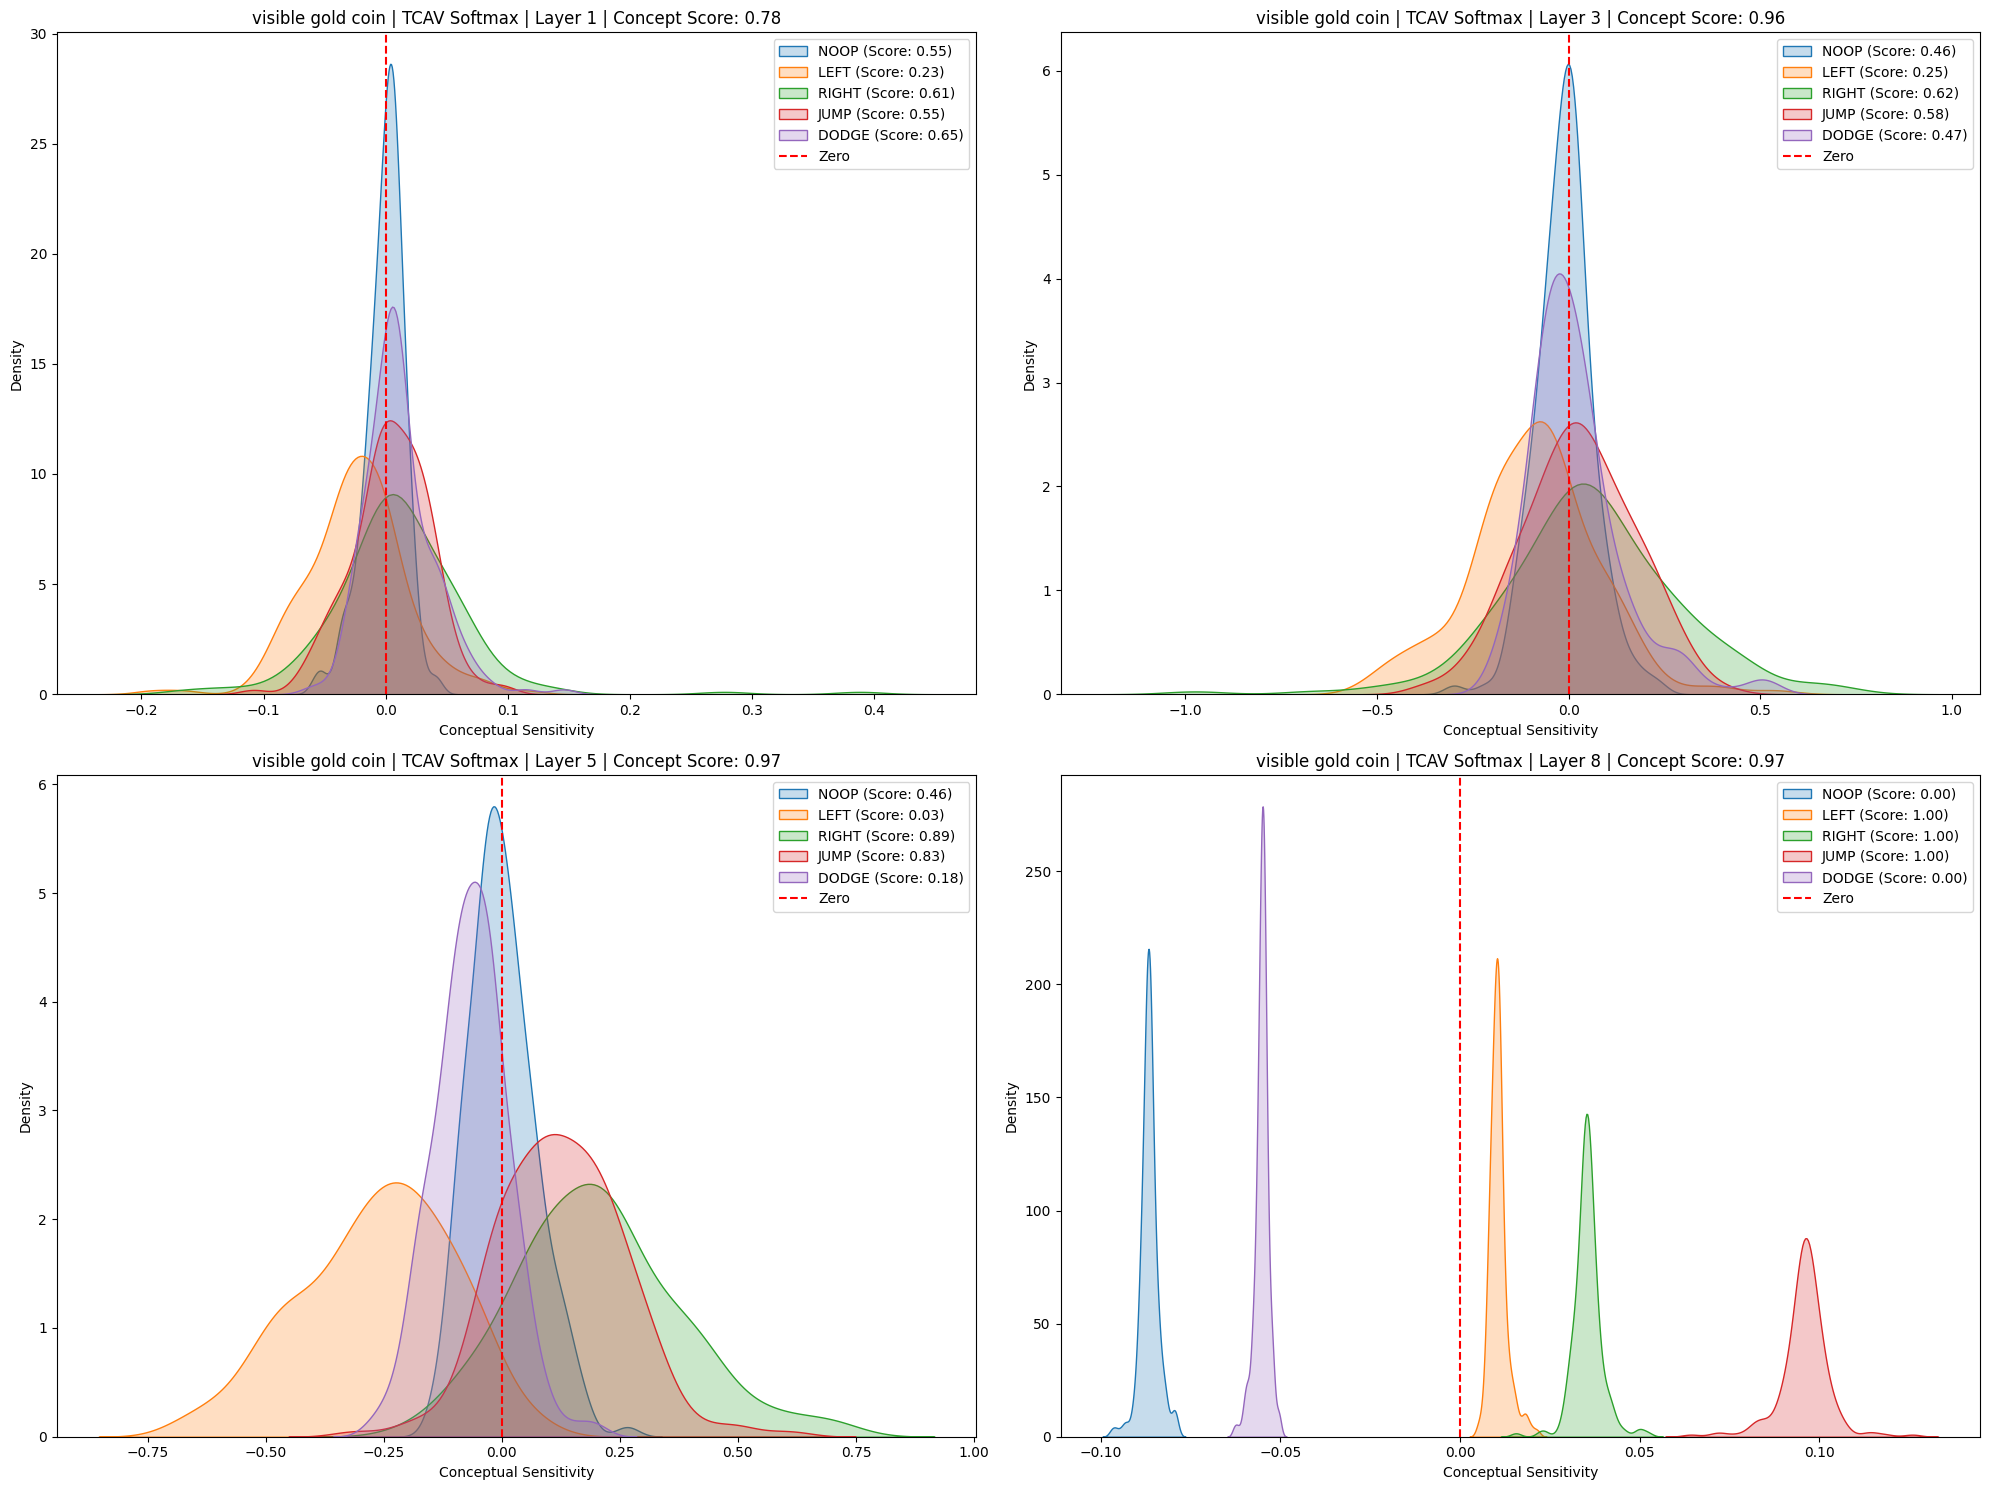

In [15]:
concept = concept_instances['Visible gold coin']

tcav_multiple_actions_analysis(
    concept=concept,
    model=model,
    layers=activation_layers,
    action_names=action_names,
    q_value_strategy=q_value_softmax,
    method_name="TCAV Softmax"
)

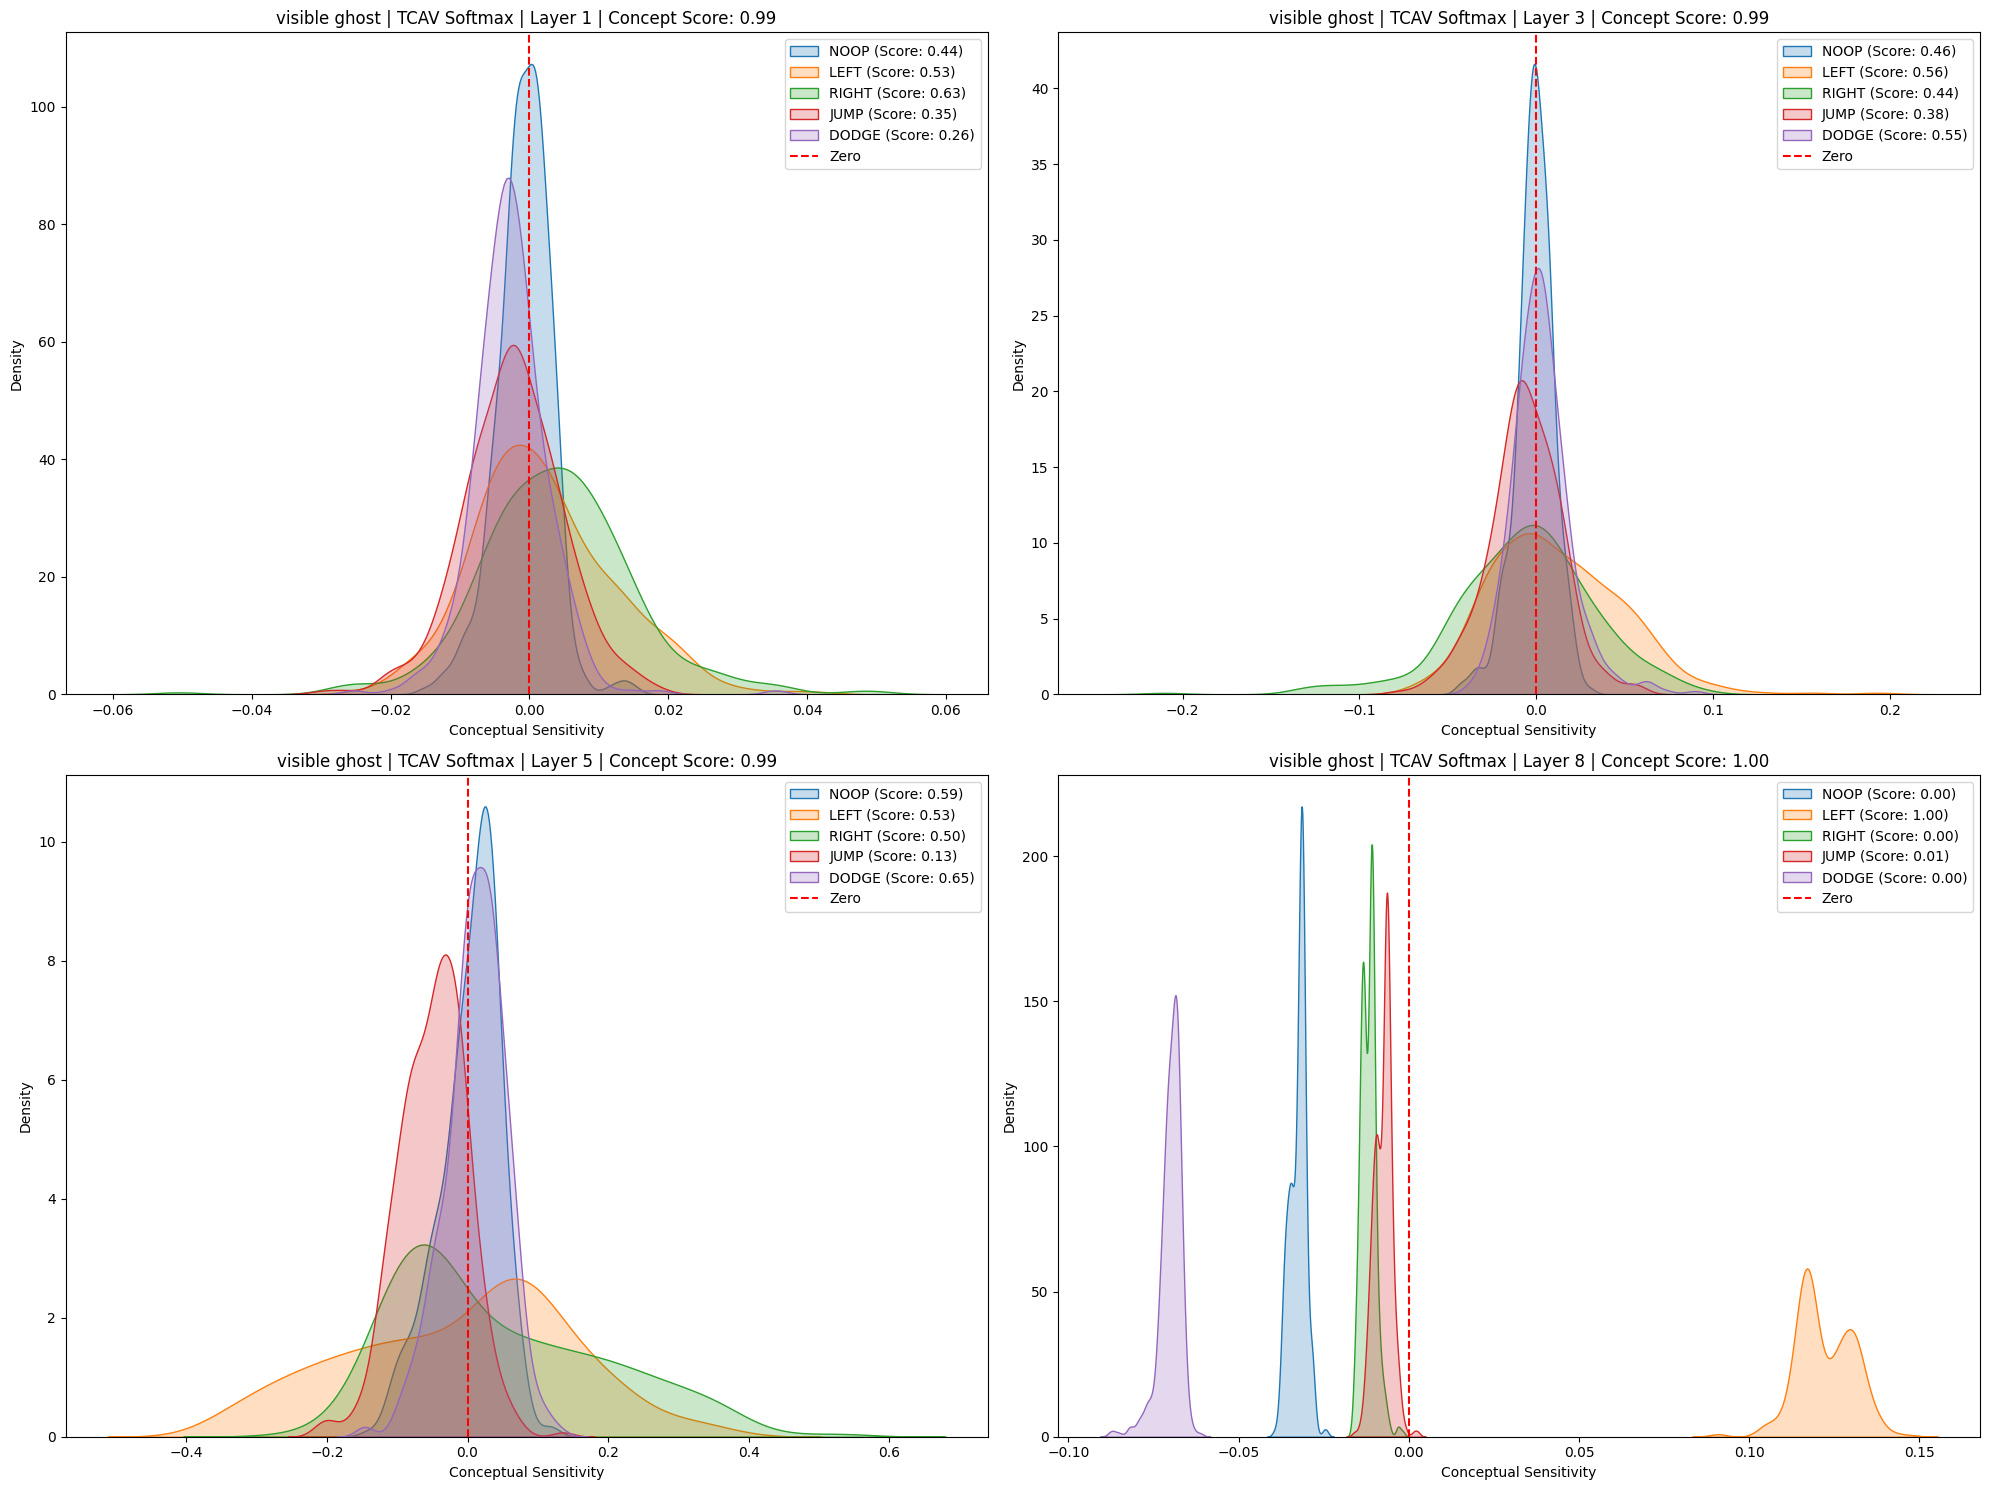

In [25]:
concept = concept_instances['Visible ghost']

tcav_multiple_actions_analysis(
    concept=concept,
    model=model,
    layers=activation_layers,
    action_names=action_names,
    q_value_strategy=q_value_softmax,
    method_name="TCAV Softmax"
)

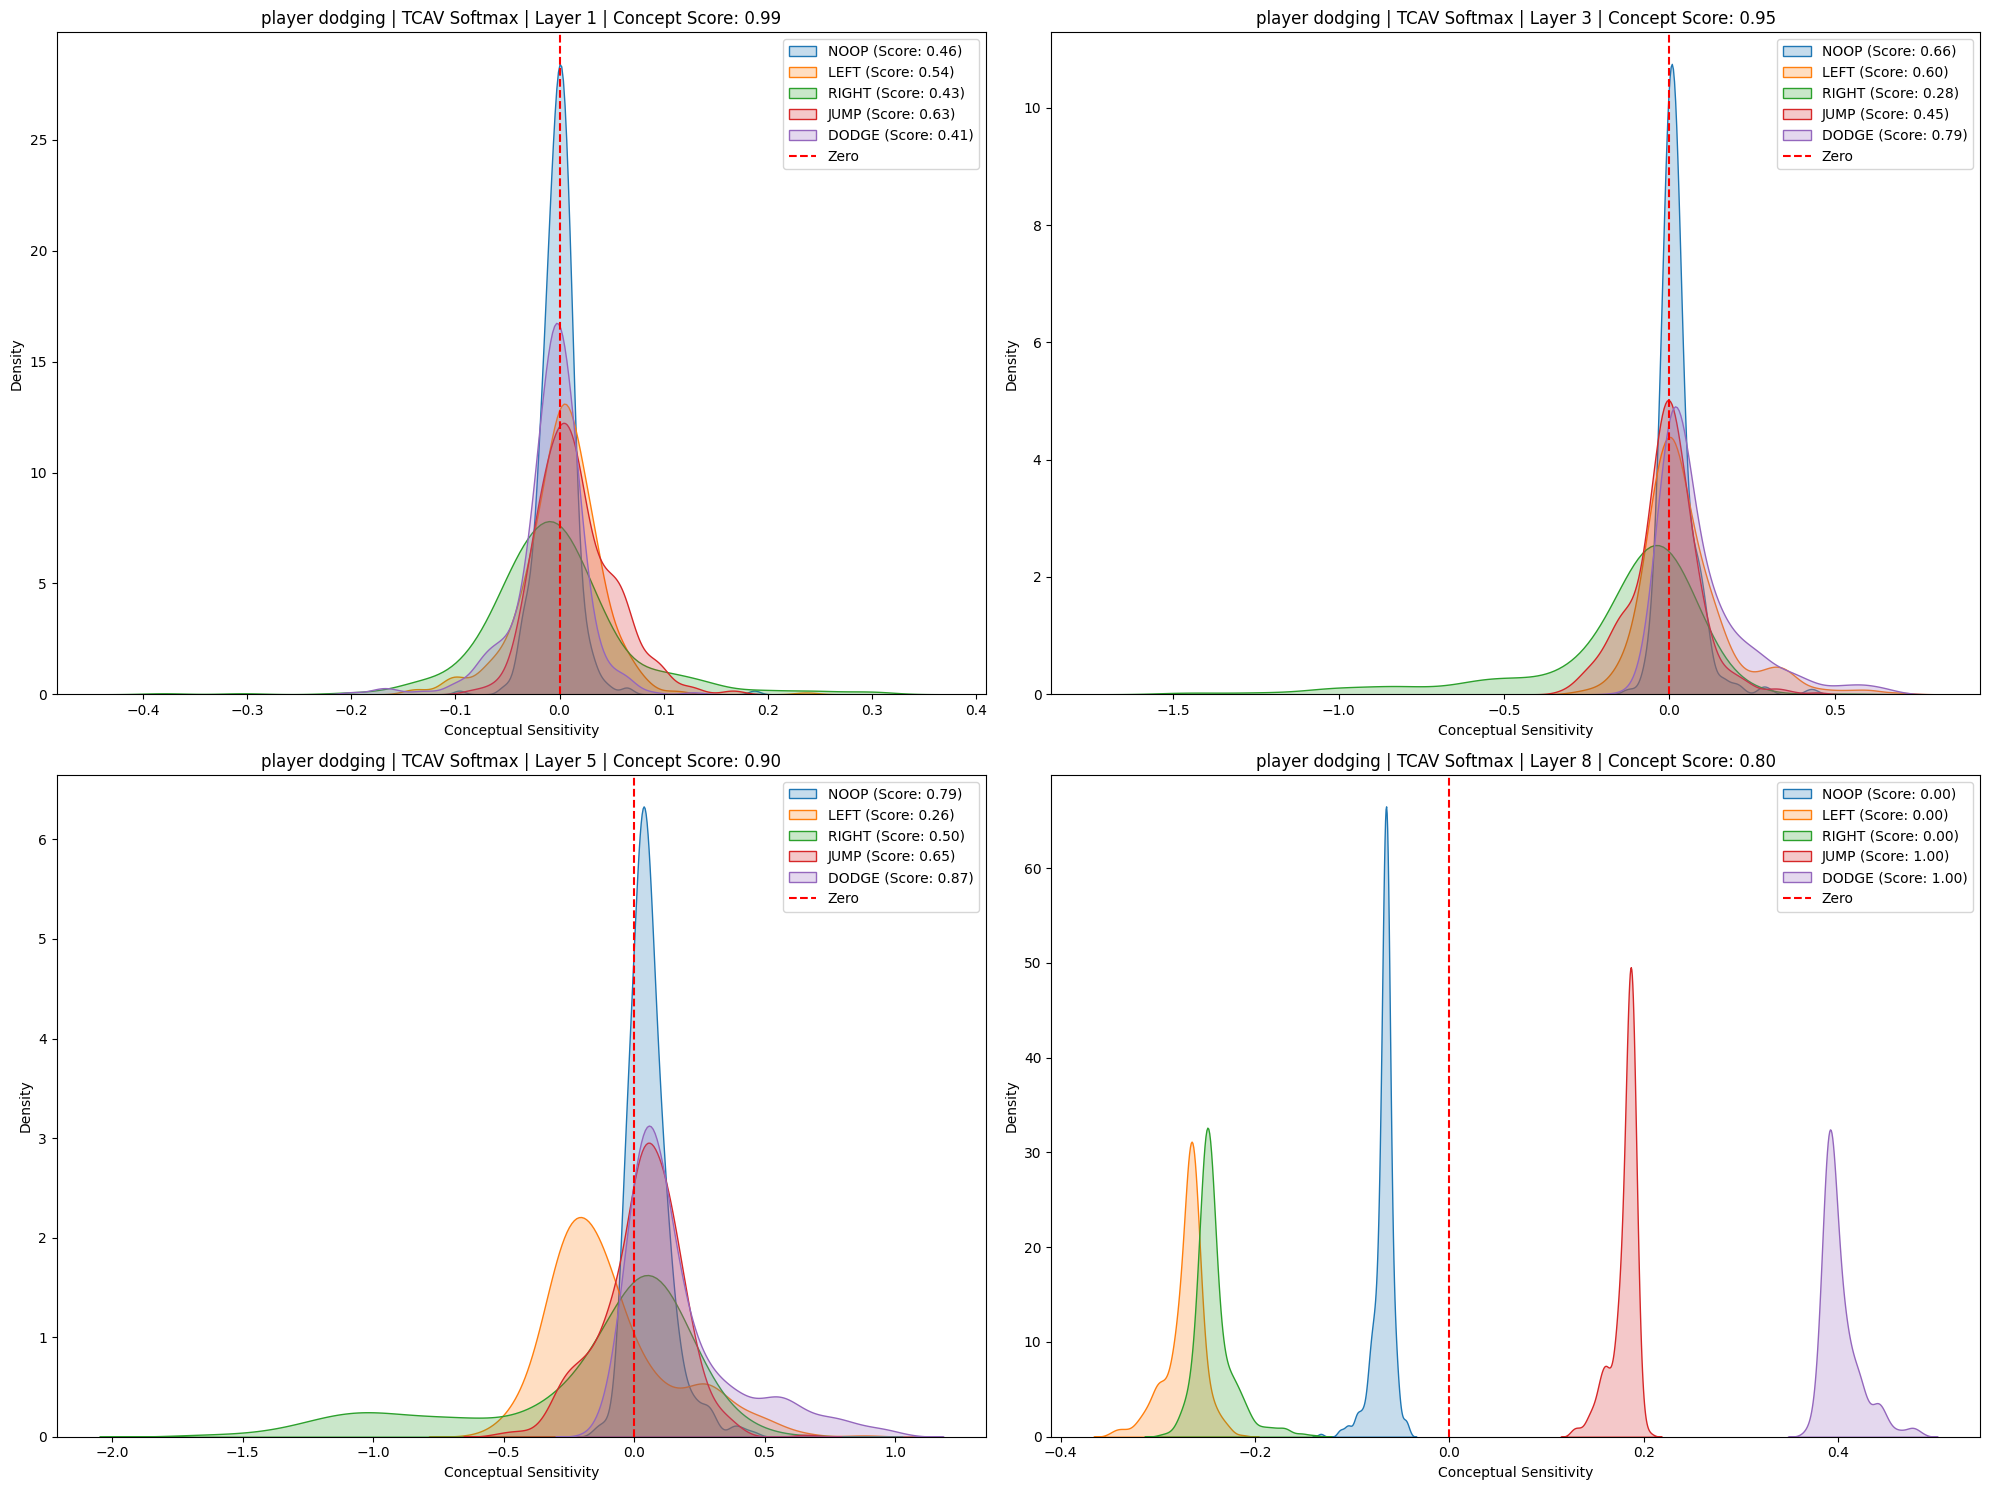

In [17]:
concept = concept_instances['Player dodging']

tcav_multiple_actions_analysis(
    concept=concept,
    model=model,
    layers=activation_layers,
    action_names=action_names,
    q_value_strategy=q_value_softmax,
    method_name="TCAV Softmax"
)

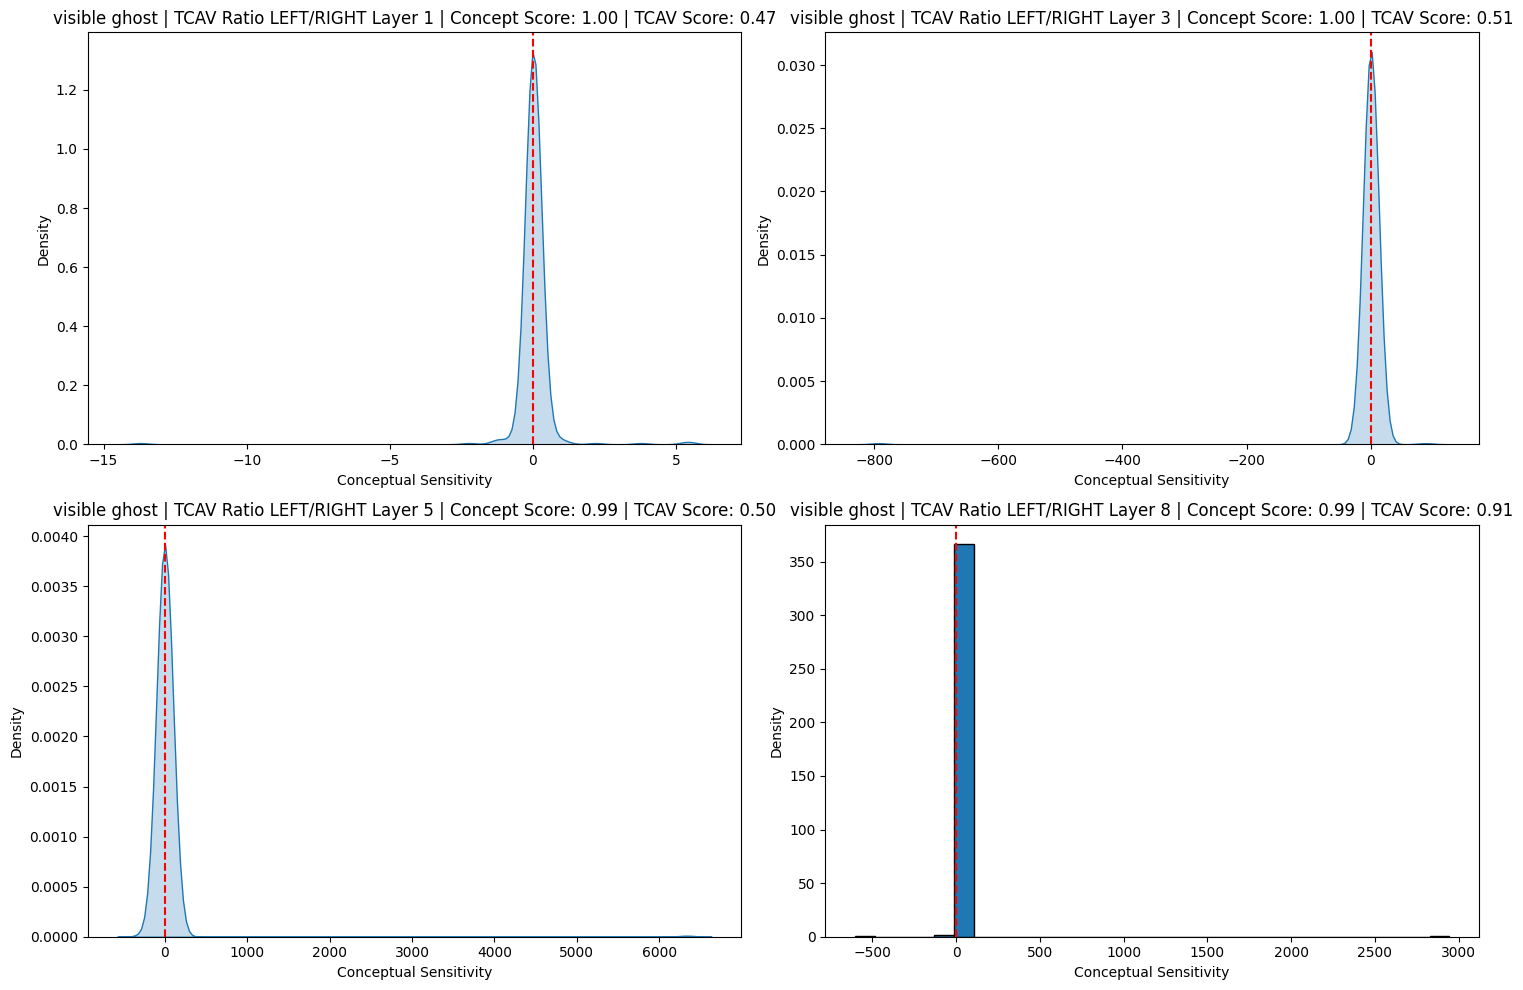

In [18]:
concept = concept_instances['Visible ghost']

action1 = 'LEFT'
action2 = 'RIGHT'
action1_idx = action_names.index(action1)
action2_idx = action_names.index(action2)

scores_tcav_ratio = tcav_analysis(
    concept=concept,
    model=model,
    layers=activation_layers,
    q_value_strategy=q_value_ratio(action1_idx, action2_idx),
    method_name=f"TCAV Ratio {action1}/{action2}"
)

In [19]:
concept1 = concept_instances['Visible bullet']
concept2 = concept_instances['Visible gold coin']

# Only use steps where either concept is present
filtered_steps = []
for step in env_steps:
    concept1_present = concept1.concept_function(step.state_variables)
    concept2_present = concept2.concept_function(step.state_variables)
    if (concept1_present or concept2_present) and concept1_present != concept2_present:
        filtered_steps.append(step)

concept_func = lambda x: concept1.concept_function(x)
relative_concept = Concept(f"{concept1.name} vs {concept2.name}", binary=True, concept_function=concept_func)
relative_concept.prepare_data(filtered_steps, max_size=10000)

# Pass train and test through model and get first activation layer
_, acts_dict_train = model(torch.tensor(relative_concept.train_obs).float(), return_acts=True)
_, acts_dict_test = model(torch.tensor(relative_concept.test_obs).float(), return_acts=True)

for layer in [1,2,3,4,5,6,7,8]:
    train_activations = acts_dict_train[layer].flatten(start_dim=1).cpu().numpy()
    test_activations = acts_dict_test[layer].flatten(start_dim=1).cpu().numpy()

    lr = LogisticRegression(max_iter=1000, solver='liblinear', penalty='l1', C=1)
    lr.fit(train_activations, relative_concept.train_values)

    # Test logistic regression on test set
    test_predictions = lr.predict(test_activations)
    test_accuracy = np.mean(test_predictions == relative_concept.test_values)
    print(f"Layer {layer} accuracy: {test_accuracy:.2f}")

# A linear probe cant distinguish bullets and gold coins
# The model can always distinguish between lava and gold coins!

Layer 1 accuracy: 0.81
Layer 2 accuracy: 0.91
Layer 3 accuracy: 0.93
Layer 4 accuracy: 0.97
Layer 5 accuracy: 0.97
Layer 6 accuracy: 0.97
Layer 7 accuracy: 0.97
Layer 8 accuracy: 0.97


## Weight inspection

0.9


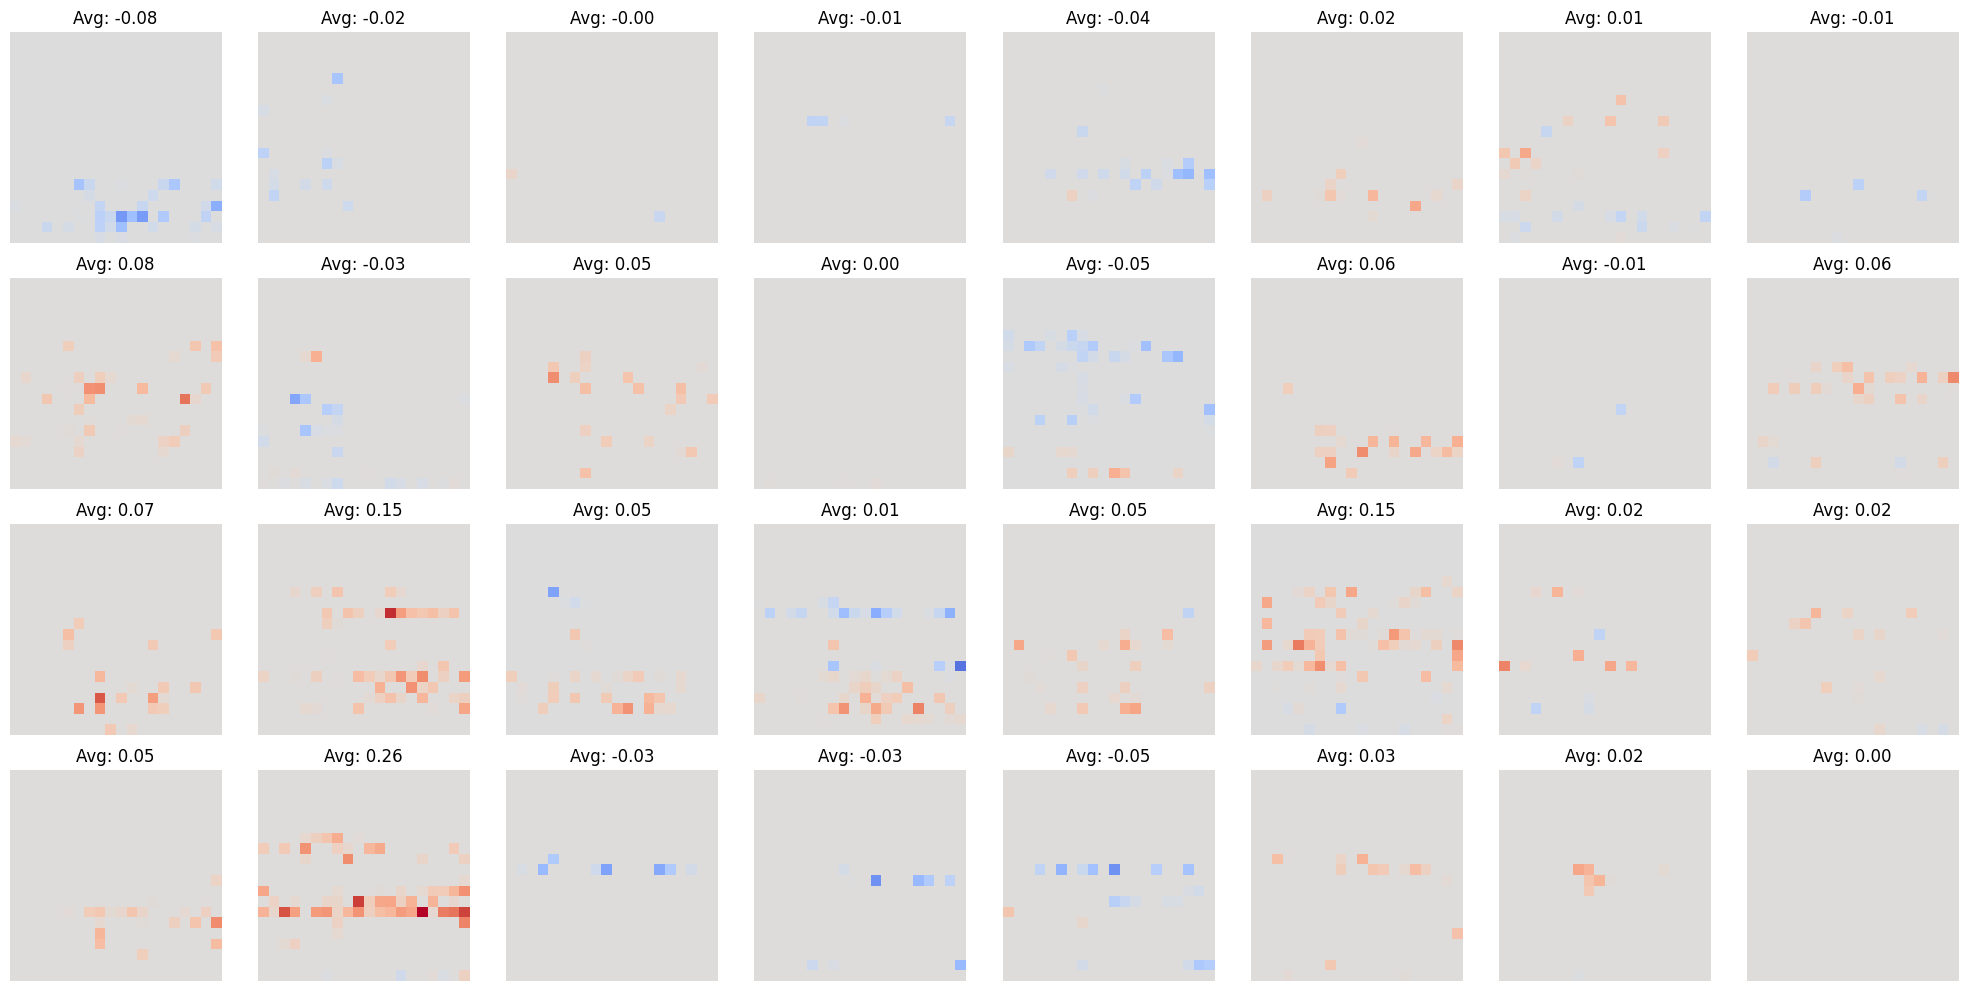

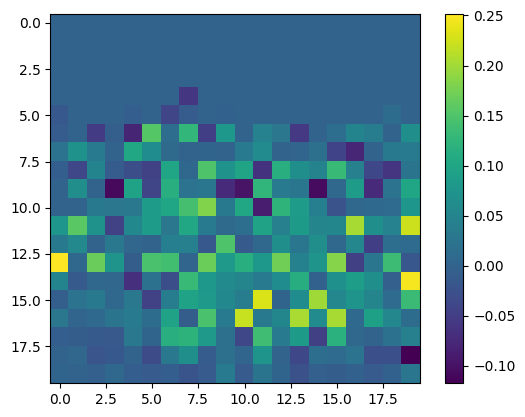

In [20]:
lr, norm_direction, acts_dict_train, acts_dict_test, probe_accuracy = prepare_probe(concept_instances['Visible bullet'], model, 1)
print(probe_accuracy)
concept_direction = lr.coef_[0].reshape(32, 20, 20)

# Determine absolute max
abs_max = np.abs(concept_direction).max()

# Plot all 32 channels of the concept direction with a unified color scale
fig, axes = plt.subplots(4, 8, figsize=(20, 10))
axes = axes.flatten()
for i in range(32):
    ax = axes[i]
    im = ax.imshow(concept_direction[i], cmap='coolwarm', vmin=-abs_max, vmax=abs_max)
    ax.axis('off')
    # Put average value in the title
    ax.set_title(f"Avg: {concept_direction[i].mean():.2f}", fontsize=12)

plt.tight_layout()
plt.show()

# Plot the average channel
average_channel = concept_direction.mean(axis=0)
plt.imshow(average_channel)
plt.colorbar()
plt.show()

(32, 3, 8, 8)


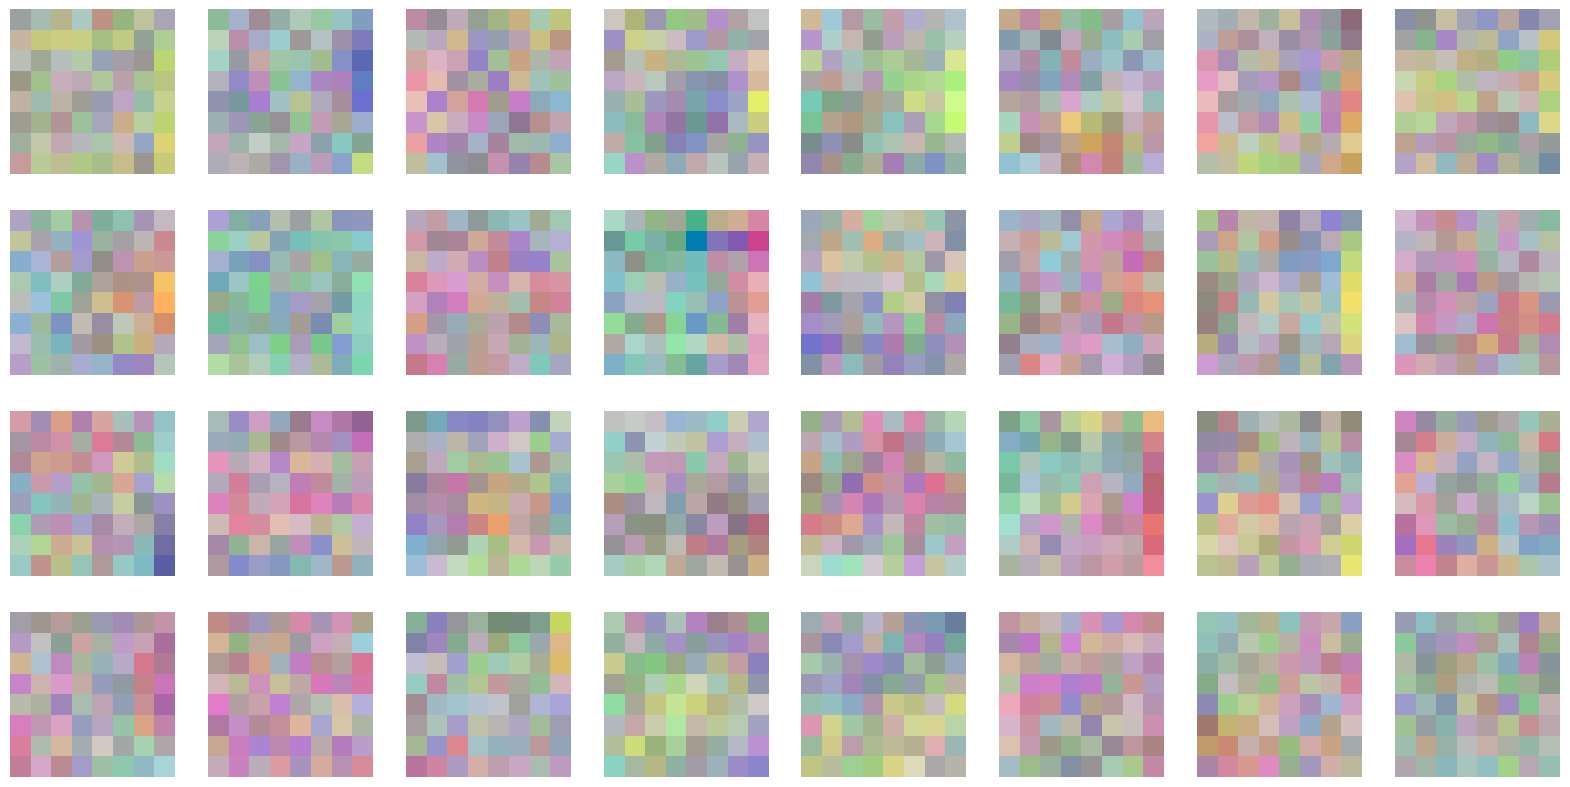

In [21]:
first_weights = model.network[0].weight.data.cpu().numpy()
first_weights = (first_weights - first_weights.min()) / (first_weights.max() - first_weights.min())
print(first_weights.shape)

# Plot all 32 channels of the first layer weights
fig, axes = plt.subplots(4, 8, figsize=(20, 10))
axes = axes.flatten()
for i in range(32):
    ax = axes[i]
    ax.imshow(first_weights[i].transpose(1, 2, 0))
    ax.axis('off')
plt.show()

0.97
tensor([0.3840], grad_fn=<MvBackward0>)
(3, 84, 84)


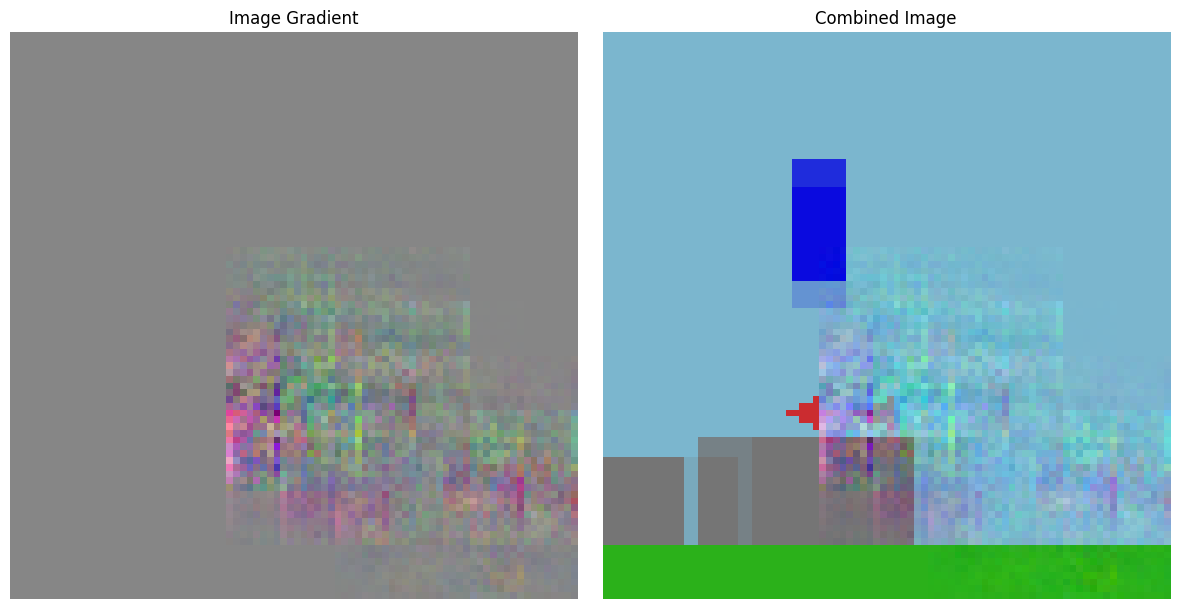

In [22]:
layer = 5
concept = concept_instances['Visible gold coin']
lr, norm_direction, acts_dict_train, acts_dict_test, probe_accuracy = prepare_probe(concept, model, layer)
print(probe_accuracy)

random_idx = random.randint(0, len(concept.test_obs) - 1)
random_image = concept.test_obs[random_idx]
random_image_tensor = torch.tensor(random_image).float().clone()

random_image_tensor = random_image_tensor.permute(2, 0, 1).unsqueeze(0)
random_image_tensor.requires_grad_(True)

# Forward pass to get activations
activation = model.network[:layer + 1](random_image_tensor / 255.0).flatten(start_dim=1)

# Compute the dot product of activations and concept vector
dot_product = torch.matmul(activation, torch.tensor(norm_direction).float())
print(dot_product)

image_grad = torch.autograd.grad(dot_product, random_image_tensor, create_graph=True)[0].squeeze().cpu().detach().numpy()

print(image_grad.shape)

image_grad = image_grad - image_grad.min()
image_grad = image_grad / image_grad.max()

# Add the image gradient to the random image
combined_image = random_image_tensor.detach() / 255.0 + image_grad
combined_image = (combined_image - combined_image.min()) / (combined_image.max() - combined_image.min())
combined_image = combined_image.squeeze().permute(1, 2, 0).cpu().numpy()

# Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(image_grad.transpose(1, 2, 0))
axes[0].set_title('Image Gradient')
axes[0].axis('off')

axes[1].imshow(combined_image)
axes[1].set_title('Combined Image')
axes[1].axis('off')

plt.tight_layout()
plt.show()

0.86
tensor([-1.9215], grad_fn=<MvBackward0>)
tensor([-1.2761], grad_fn=<MvBackward0>)
more or positive?: tensor([True])


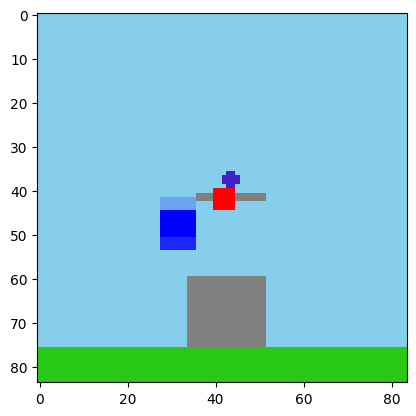

In [23]:
layer = 1
concept = concept_instances['Visible gold coin']
lr, norm_direction, acts_dict_train, acts_dict_test, probe_accuracy = prepare_probe(concept, model, layer)
print(probe_accuracy)

random_idx = random.randint(0, len(concept.test_obs) - 1)
random_image = concept.test_obs[random_idx]
random_image_tensor = torch.tensor(random_image).float().clone()
random_image_tensor = random_image_tensor.permute(2, 0, 1).unsqueeze(0)
random_image_tensor.requires_grad_(True)
activation = model.network[:layer + 1](random_image_tensor / 255.0).flatten(start_dim=1)

# Compute the dot product of activations and concept vector
dot_product_before = torch.matmul(activation, torch.tensor(norm_direction).float())
print(dot_product_before)

# Make a pixel yellow and recompute dot product
random_image_tensor = random_image_tensor.clone()
random_image_tensor[0, 0, 40:45, 40:45] = 255
random_image_tensor[0, 1, 40:45, 40:45] = 0
random_image_tensor[0, 2, 40:45, 40:45] = 0
random_image_tensor.requires_grad_(True)

activation = model.network[:layer + 1](random_image_tensor / 255.0).flatten(start_dim=1)
dot_product_after = torch.matmul(activation, torch.tensor(norm_direction).float())
print(dot_product_after)

print(f"more or positive?: {dot_product_after >= dot_product_before}")

# Plot random_image_tensor
plt.imshow(random_image_tensor.squeeze().permute(1, 2, 0).detach().numpy().astype(np.uint8))
plt.show()

### What are the tails and sudden spikes in the TCAV scores?

1. Visible bullet x Right, has a long negative tail. Is that walking towards the bullet?
2. Gold coin, layer 5, RIGHT. is that bump when the model actually gets the coin?
3. Visible ghost last layer, why doesnt JUMP and DODGE have bimodal distributions like the other actions? What determines if an action is bimodal?

### Should we even use TCAV in conv layers?

TCAV probes can use arbitrary positional neurons, e.g., a gold coin can be detected anywhere in the screen.

What if the DQN only detects gold coins to its right? Conv layers are not that truthful then.

Can we check which positions that is used in the first FC layer?

Original shape of fc: (512, 3136)
Reshaped fc: (512, 64, 7, 7)


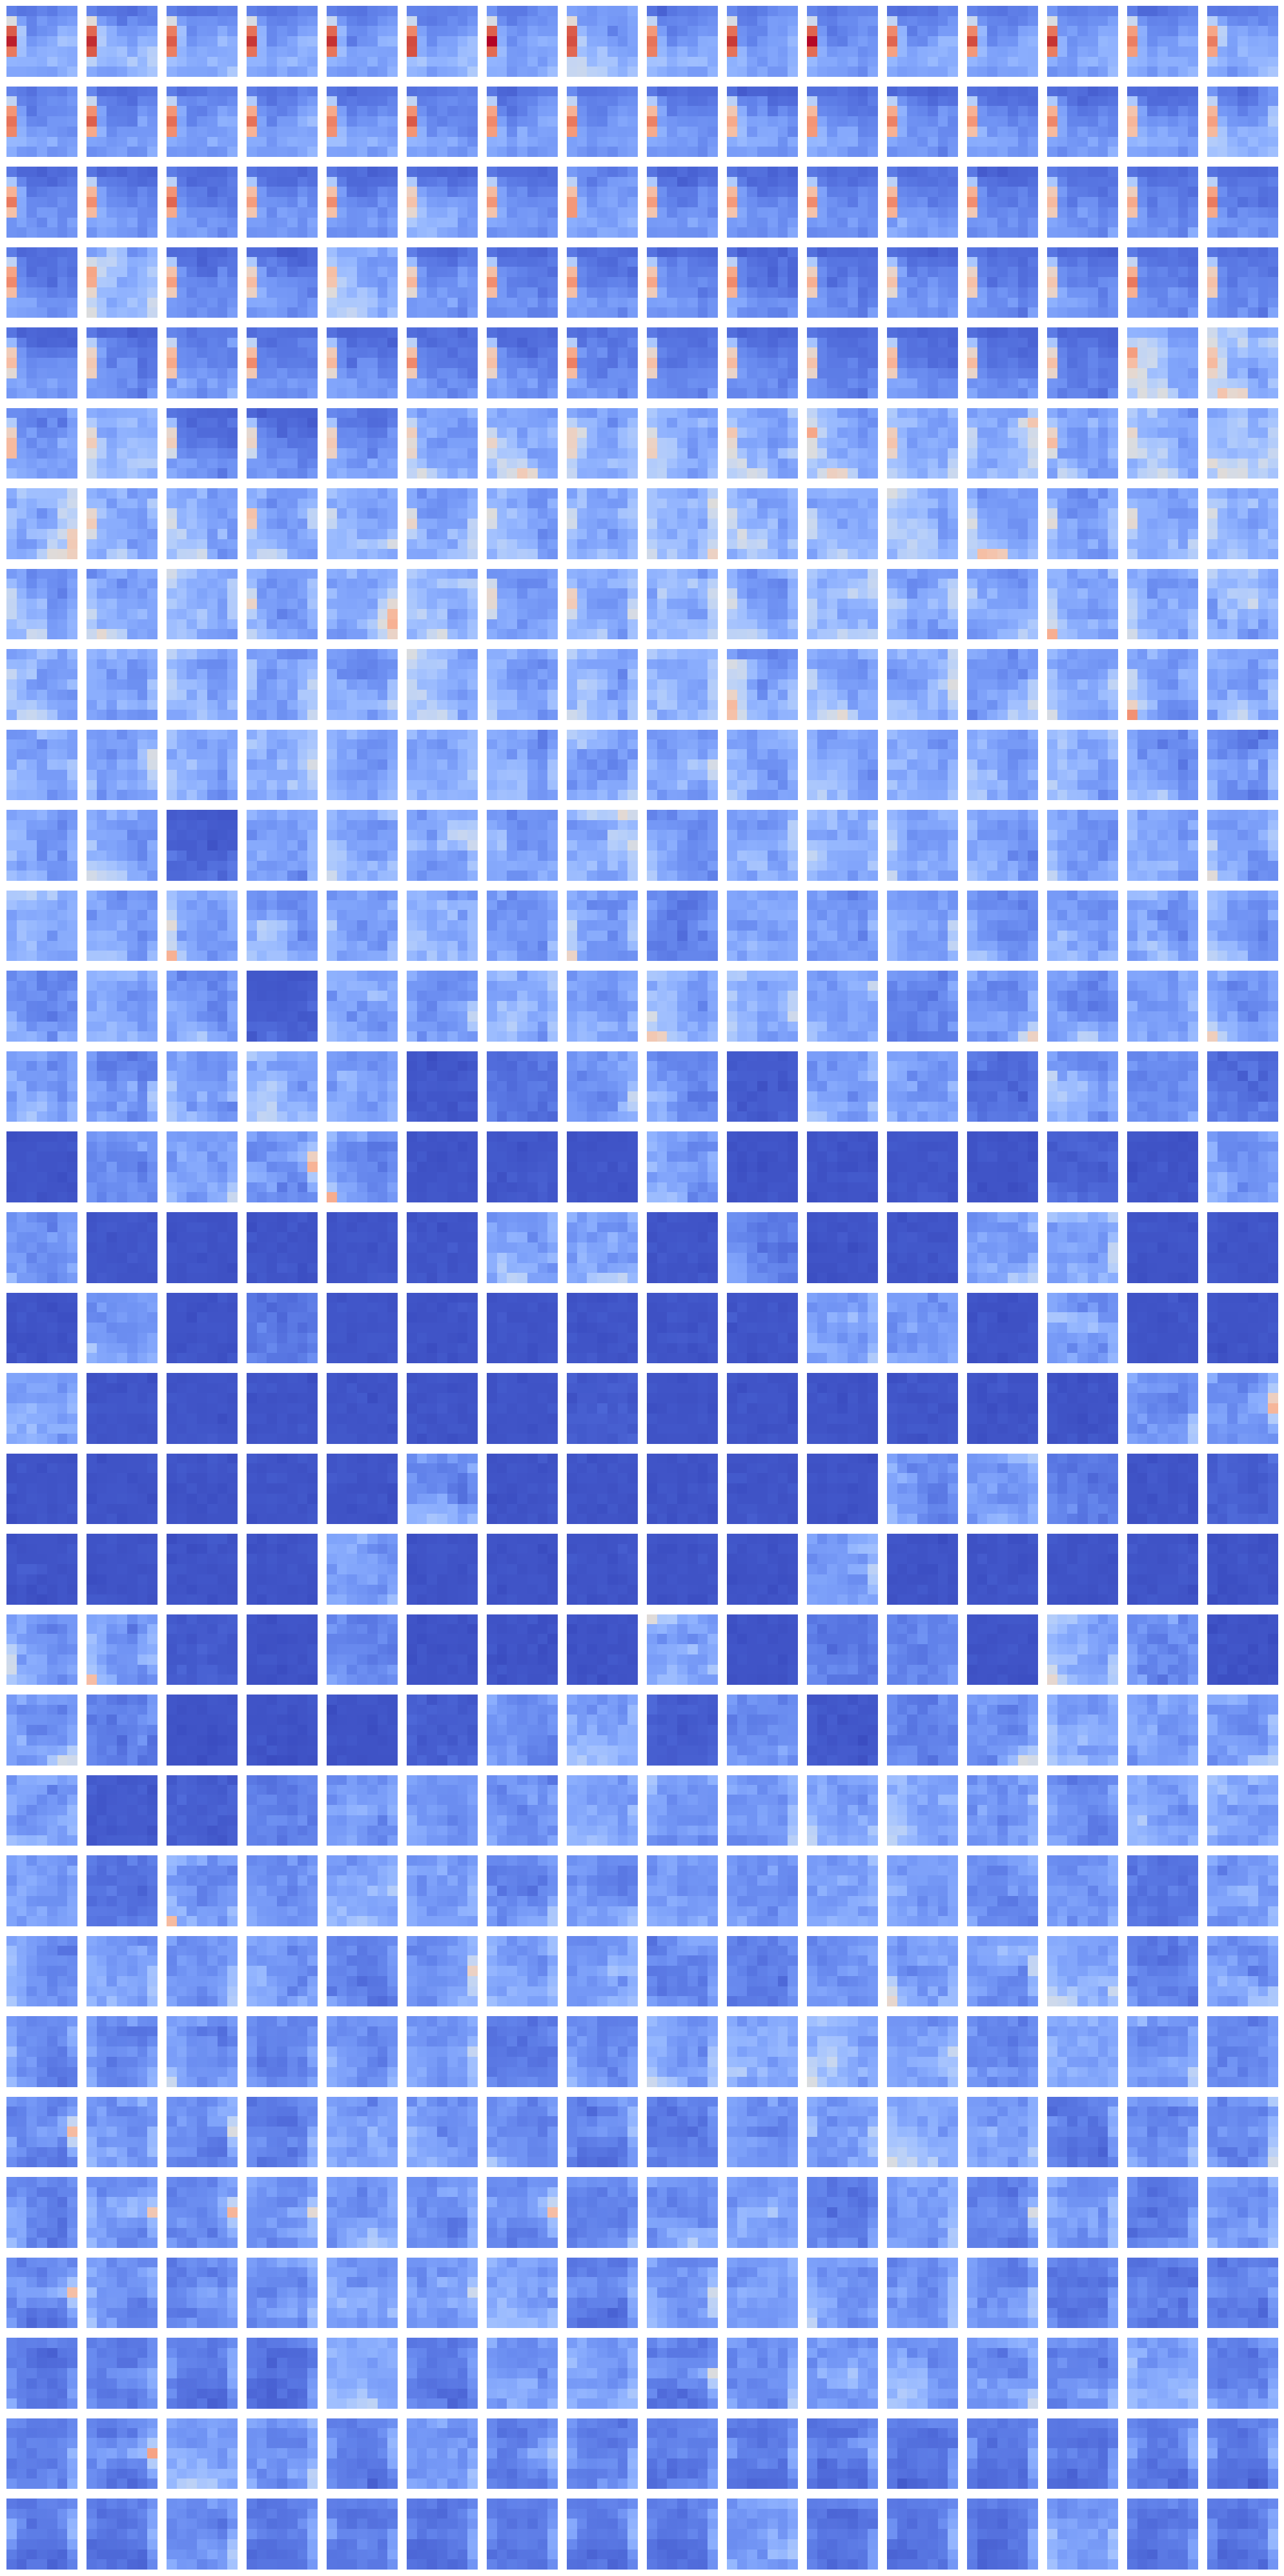

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Extract and preprocess weights
fc = model.network[7].weight.detach().numpy()
print(f"Original shape of fc: {fc.shape}")
fc = fc.reshape(512, 64, 7, 7)
print(f"Reshaped fc: {fc.shape}")

# Flatten weights for PCA: each neuron has 64*7*7 = 3136 weights
flattened_weights = fc.reshape(512, -1)  # Shape: (512, 3136)

# Apply PCA to reduce each neuron's weights to 1D
pca = PCA(n_components=1)
pca_scores = pca.fit_transform(flattened_weights)  # Shape: (512, 1)

# Sort neurons based on PCA scores
sorted_indices = np.argsort(pca_scores.flatten())
sorted_fc = fc[sorted_indices][::-1]

# Calculate mean absolute weights across the 64 channels
mean_abs_weights = np.abs(sorted_fc).mean(axis=1)  # Shape: (512, 7, 7)

# Set global min and max for color scale consistency across subplots
global_min = np.min(mean_abs_weights)
global_max = np.max(mean_abs_weights)

# Plot the sorted weights
fig, axes = plt.subplots(32, 16, figsize=(20, 40))  # Increased figsize for better visibility
axes = axes.flatten()
for i in range(512):
    ax = axes[i]
    im = ax.imshow(mean_abs_weights[i], cmap='coolwarm', vmin=global_min, vmax=global_max)
    ax.axis('off')
plt.tight_layout()
plt.show()